In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.nasnet import NASNetLarge,preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortexNoLegend"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (331,331,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(331, 331))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 331, 331, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [ ]:
# Training the model from scratch
num_epochs=100
image_shape = (331, 331, 3)                                                                                                                                                                                                                                                                                            
history = []
checkpointer = ModelCheckpoint(filepath='weights-portex_nolegend-nasnetlarge-Adam-%depochs-fromscratch.h5' %(num_epochs), monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = NASNetLarge(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=8, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9114/9114 [==============================] - 1052s 115ms/step - loss: 0.0201 - acc: 0.9941 - val_loss: 6.0500 - val_acc: 0.5352
Epoch 61/100
9114/9114 [==============================] - 1056s 116ms/step - loss: 0.0258 - acc: 0.9922 - val_loss: 1.6337 - val_acc: 0.7172
Epoch 62/100
9116/9116 [==============================] - 3255s 357ms/step - loss: 0.0738 - acc: 0.9750 - val_loss: 9.3335 - val_acc: 0.1647
Epoch 26/100
9116/9116 [==============================] - 1237s 136ms/step - loss: 0.0770 - acc: 0.9744 - val_loss: 8.1032 - val_acc: 0.3559
Epoch 27/100
9116/9116 [==============================] - 1067s 117ms/step - loss: 0.0645 - acc: 0.9819 - val_loss: 11.3618 - val_acc: 0.2206
Epoch 28/100
9116/9116 [==============================] - 1065s 117ms/step - loss: 0.0677 - acc: 0.9782 - val_loss: 12.8457 - val_acc: 0.1559
Epoch 29/100
9125/9125 [==============================] - 981s 108ms/step - loss: 0.0969 - acc: 0.9692 - 

In [10]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9382


In [11]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

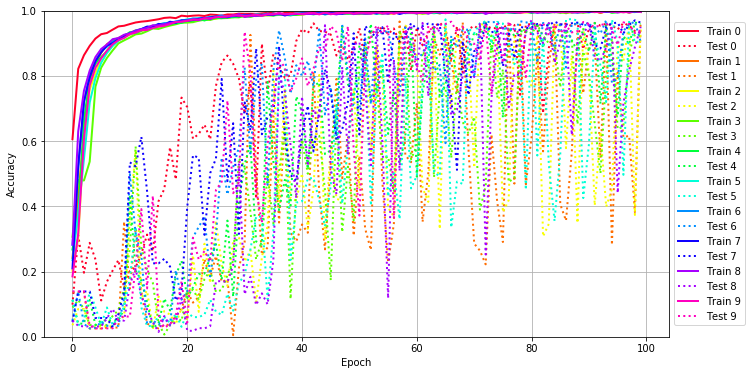

In [12]:
plot_acc(history)

In [13]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

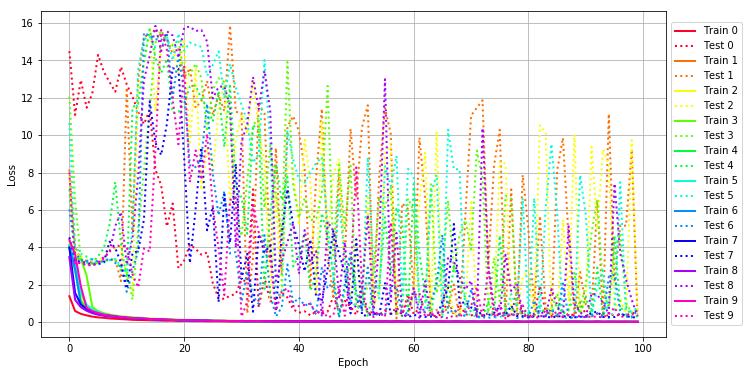

In [14]:
plot_loss(history)

Plotting the confusion matrix


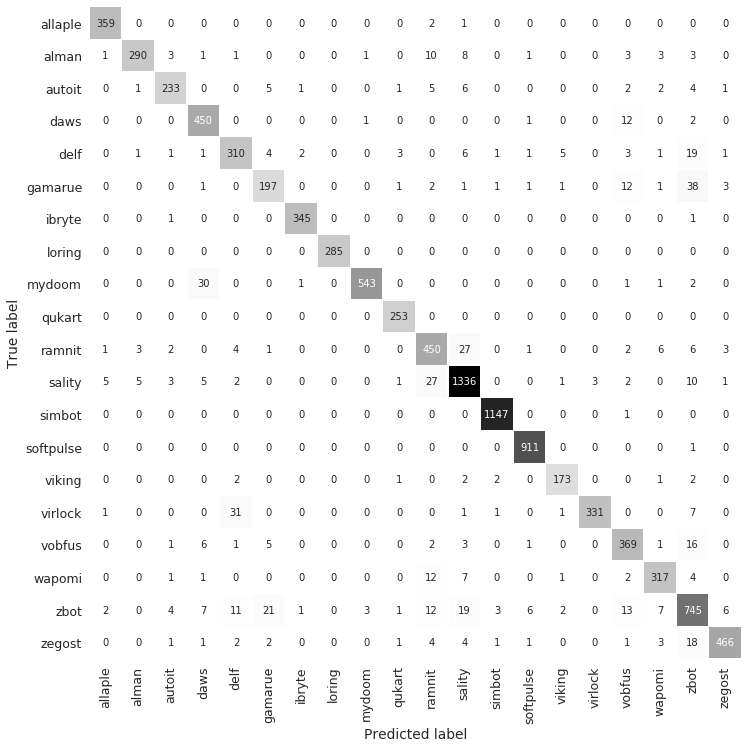

In [15]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


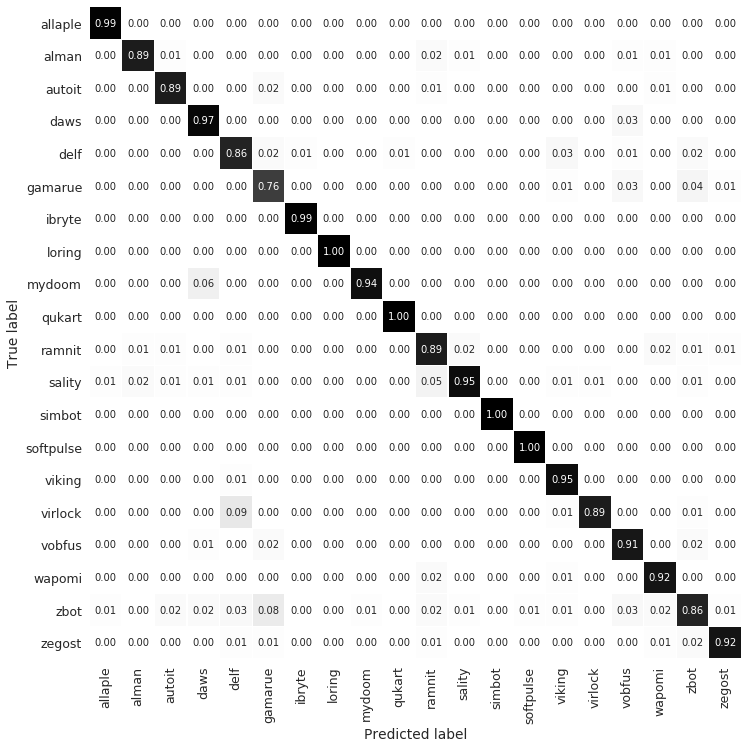

In [16]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
for h in history:
    print(h.history)

{'val_loss': [14.495554982684553, 11.082788788015023, 12.950103412382305, 11.470011570490897, 12.235424560494721, 14.297872536815703, 13.395018752664328, 12.844107292592525, 12.324681927450001, 13.654683207161725, 12.719525444866449, 12.067850372746491, 11.237946210885752, 10.591416121496154, 11.345796982292086, 8.153383604516138, 7.311147251694598, 5.118020103852185, 6.345674740320753, 2.8801577608342708, 3.2870271545922103, 4.145185556735109, 3.9133484009390855, 3.6076945822802275, 3.7163758639814746, 2.070894628030253, 1.277540878098379, 1.238349385222944, 1.4088103453057597, 1.502483861654536, 2.2517716178089007, 2.1738905686345533, 7.102679646515868, 0.7758600458292211, 2.398811610217554, 1.096970655166317, 1.2490360039288926, 1.5757963604822514, 1.3115442032012692, 0.6814860820568978, 0.49654979369428676, 0.5759051977817375, 0.3532588804889226, 0.5627491943391182, 0.44087150952981835, 0.5553533530249151, 1.3772282446430943, 0.6303367104074415, 1.1355060816110056, 0.82338528323860

In [18]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

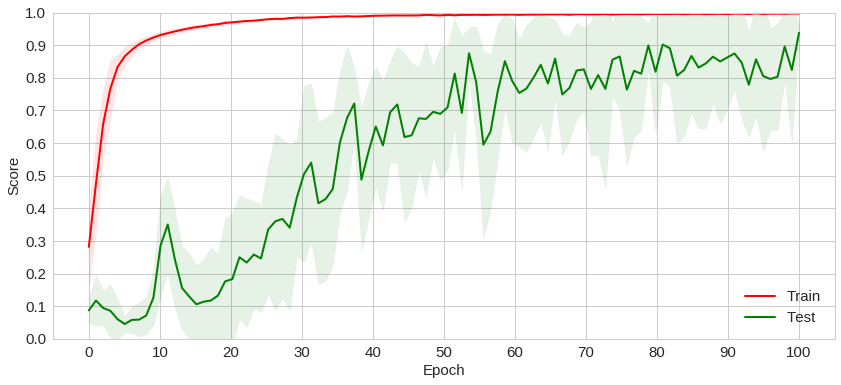

In [19]:
plot_mean_acc(history)

In [20]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

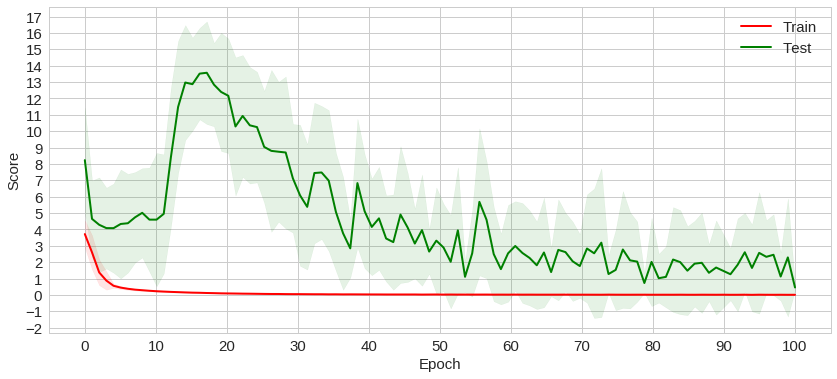

In [21]:
plot_mean_loss(history)

In [22]:
hist = [{'val_loss': [14.495554982684553, 11.082788788015023, 12.950103412382305, 11.470011570490897, 12.235424560494721, 14.297872536815703, 13.395018752664328, 12.844107292592525, 12.324681927450001, 13.654683207161725, 12.719525444866449, 12.067850372746491, 11.237946210885752, 10.591416121496154, 11.345796982292086, 8.153383604516138, 7.311147251694598, 5.118020103852185, 6.345674740320753, 2.8801577608342708, 3.2870271545922103, 4.145185556735109, 3.9133484009390855, 3.6076945822802275, 3.7163758639814746, 2.070894628030253, 1.277540878098379, 1.238349385222944, 1.4088103453057597, 1.502483861654536, 2.2517716178089007, 2.1738905686345533, 7.102679646515868, 0.7758600458292211, 2.398811610217554, 1.096970655166317, 1.2490360039288926, 1.5757963604822514, 1.3115442032012692, 0.6814860820568978, 0.49654979369428676, 0.5759051977817375, 0.3532588804889226, 0.5627491943391182, 0.44087150952981835, 0.5553533530249151, 1.3772282446430943, 0.6303367104074415, 1.1355060816110056, 0.8233852832386034, 0.3833373503544041, 1.3657292240236423, 0.4744083183773843, 0.5413297353932173, 0.4058524654435439, 0.5953977851630734, 0.4431019182237991, 0.770641986127924, 0.38432578050255484, 1.4723159638119854, 0.4234237014538903, 0.7300762526140613, 0.5072491528374978, 0.3590945285746481, 0.3050912569181218, 0.45100373702776897, 1.1782157499047088, 0.3992823828544816, 0.9527431166224409, 0.417332582191674, 0.3538537303868805, 0.45261139114916205, 0.35902011733032957, 0.45559105578931436, 0.37687620668072197, 0.3533534022915007, 0.31760269589567625, 0.30578987513283984, 1.6865086542296197, 0.31448760486845895, 0.35471716445528645, 0.31226851200266115, 1.9389315167065022, 0.5384269236929913, 0.43627932550591075, 0.3044379025937831, 0.27614732700338784, 0.44030400260205127, 0.3509111430640326, 1.0590282388309233, 0.391157383714849, 0.2999230220379252, 0.4517006099669959, 0.34178692071638817, 0.35386828453355235, 0.39285433810513126, 0.3398433529772179, 0.37890602600971934, 0.44873557293225896, 0.5750944248960161], 'loss': [1.3786877105086126, 0.588485639719775, 0.4363660965831517, 0.35561196746356144, 0.2890373588142274, 0.24670198819676906, 0.22538139387857678, 0.19136920452995482, 0.17442004076894896, 0.15452041747766, 0.13900497110331692, 0.1171349929721164, 0.10631515043083954, 0.10175552807732706, 0.09011381229995911, 0.0841486655864861, 0.07546343483916035, 0.06807165780954755, 0.07071549272285034, 0.04977065444259867, 0.054741380055173185, 0.05083157667703684, 0.048278682698419145, 0.04801509687120813, 0.0398297874973615, 0.04237614400401783, 0.044350824685666576, 0.03369897960757682, 0.03637451553089172, 0.029967059179347243, 0.02943901557500415, 0.030476188304016744, 0.030385782501949274, 0.02746774347469149, 0.022978100584025583, 0.02215578222819454, 0.04049261794966073, 0.01780869628174859, 0.025748373156288102, 0.02193200576447592, 0.024548113712278795, 0.03068070339611152, 0.010980485945238844, 0.020063390502099418, 0.026365528802143094, 0.017155225020398453, 0.024106543448274287, 0.010676379285132861, 0.025434327766202504, 0.01714640946503043, 0.011906095486393046, 0.026865325595663105, 0.021306805773929335, 0.018247280774641137, 0.016339259392612743, 0.01444700274392981, 0.024290868552112068, 0.015466600234400888, 0.011261673760815884, 0.021053554892884373, 0.01785520645856551, 0.008631676037788371, 0.012260040105067153, 0.026713404149429014, 0.006335110003954895, 0.014238269844617447, 0.016044955691753002, 0.014119353265209331, 0.01791649182299287, 0.014623306241956105, 0.01543359830185792, 0.010464097725572434, 0.014553799095912229, 0.014883490074966895, 0.015803948198741546, 0.014547195926682733, 0.009433120943821172, 0.00879321148402738, 0.01930884795056577, 0.012721067788443596, 0.015835243862288344, 0.007854917437632492, 0.01260951345612959, 0.013979869219706002, 0.01254137538609293, 0.008981355036416977, 0.004586715743246331, 0.02024006779566944, 0.008372145274598434, 0.01963001609288312, 0.00853180289930921, 0.00809346386247067, 0.021564519373634863, 0.00752247068068912, 0.012184384826833714, 0.011387197330378067, 0.005970604878423242, 0.009822909492995585, 0.008237809065609685, 0.015425887291623126], 'val_acc': [0.0986328125, 0.3115234375, 0.1962890625, 0.2880859375, 0.2373046875, 0.111328125, 0.1689453125, 0.203125, 0.2353515625, 0.1494140625, 0.2021484375, 0.212890625, 0.25390625, 0.3134765625, 0.26171875, 0.416015625, 0.453125, 0.5810546875, 0.482421875, 0.7333984375, 0.7041015625, 0.607421875, 0.6220703125, 0.650390625, 0.60546875, 0.76953125, 0.841796875, 0.8623046875, 0.8369140625, 0.7919921875, 0.6845703125, 0.779296875, 0.423828125, 0.8984375, 0.7490234375, 0.8662109375, 0.830078125, 0.7939453125, 0.8017578125, 0.9072265625, 0.943359375, 0.9306640625, 0.9609375, 0.9375, 0.935546875, 0.9267578125, 0.8623046875, 0.89453125, 0.8486328125, 0.8828125, 0.9462890625, 0.841796875, 0.939453125, 0.9287109375, 0.9521484375, 0.927734375, 0.9453125, 0.9013671875, 0.9501953125, 0.81640625, 0.94921875, 0.8935546875, 0.9326171875, 0.951171875, 0.962890625, 0.9453125, 0.8515625, 0.9521484375, 0.810546875, 0.943359375, 0.953125, 0.94140625, 0.953125, 0.9462890625, 0.9462890625, 0.947265625, 0.958984375, 0.9560546875, 0.7421875, 0.95703125, 0.958984375, 0.9599609375, 0.685546875, 0.8857421875, 0.9462890625, 0.9580078125, 0.9599609375, 0.953125, 0.9609375, 0.8818359375, 0.9443359375, 0.9619140625, 0.9541015625, 0.9599609375, 0.955078125, 0.9423828125, 0.9619140625, 0.9541015625, 0.9375, 0.931640625], 'acc': [0.6059043020193152, 0.8215539947322212, 0.8633669885864794, 0.8920105355575065, 0.9143985952589991, 0.9277875329236172, 0.9314091308165057, 0.9417251975417033, 0.9516022827041264, 0.9536874451273046, 0.9588454784899034, 0.9636742756804214, 0.9663081650570676, 0.9679543459174714, 0.9708077260755048, 0.9736611062335382, 0.977721685689201, 0.9790386303775241, 0.9769534679543459, 0.9845258999122037, 0.9826602282704127, 0.9845258999122037, 0.9854038630377524, 0.9835381913959613, 0.987928007023705, 0.9868305531167691, 0.9845258999122037, 0.9883669885864794, 0.9881474978050921, 0.9907813871817384, 0.990342405618964, 0.9904521510096576, 0.9900131694468832, 0.9915496049165935, 0.9931957857769974, 0.9925373134328358, 0.9867208077260755, 0.9934152765583846, 0.9924275680421423, 0.9935250219490781, 0.992756804214223, 0.9900131694468832, 0.9958296751536435, 0.9938542581211589, 0.9923178226514486, 0.9944029850746269, 0.9930860403863038, 0.9969271290605795, 0.9930860403863038, 0.9950614574187884, 0.9968173836698858, 0.9917690956979807, 0.9928665496049166, 0.9942932396839332, 0.995171202809482, 0.9952809482001755, 0.9934152765583846, 0.9955004389815628, 0.9961589113257243, 0.9937445127304653, 0.9944029850746269, 0.9972563652326603, 0.9965978928884986, 0.9926470588235294, 0.9981343283582089, 0.9956101843722563, 0.9949517120280948, 0.9950614574187884, 0.9955004389815628, 0.9950614574187884, 0.9949517120280948, 0.9970368744512731, 0.9963784021071115, 0.9959394205443372, 0.9958296751536435, 0.99571992976295, 0.9970368744512731, 0.9978050921861282, 0.9938542581211589, 0.9960491659350307, 0.9952809482001755, 0.9974758560140474, 0.9960491659350307, 0.9956101843722563, 0.9967076382791923, 0.9971466198419666, 0.9986830553116769, 0.9944029850746269, 0.9971466198419666, 0.9949517120280948, 0.9967076382791923, 0.9973661106233538, 0.9942932396839332, 0.9973661106233538, 0.9963784021071115, 0.9969271290605795, 0.997585601404741, 0.9974758560140474, 0.9974758560140474, 0.9958296751536435]},
{'val_loss': [8.158223421547978, 4.0198670441390485, 3.356523510061365, 3.2750785187499165, 3.175930391785683, 3.1952731940611003, 3.286556620887114, 3.2988867955665064, 3.3500937827645916, 2.1885852723322268, 12.546215795024267, 4.851554750136798, 12.956814128556402, 15.329740026925641, 15.280575789584105, 15.708046006129912, 15.300159159471844, 15.131199424280812, 14.357958108711616, 14.605829640478484, 13.061304796257037, 13.587312332571369, 11.459446938696777, 11.833194680847301, 12.897087972546947, 11.085140986517168, 12.123942239727613, 11.288990517768374, 15.872781436270698, 11.250813602001466, 11.190382940516535, 0.4650544518849375, 3.5006877205173508, 11.599591598941556, 11.183504682851895, 3.2362199365098574, 9.310364339208371, 2.5178684549147894, 10.444295799189113, 11.02261068095134, 10.213335081326823, 8.146511205713974, 1.933385269641432, 7.758084394119009, 11.413177051306805, 3.6615227044973757, 1.3715268366789122, 7.958078539240996, 3.3239729097889046, 10.344812706737352, 6.648021630005923, 10.426184728596668, 11.599587607789458, 0.755251053775721, 7.850382987612654, 11.457910464001262, 10.08378413526489, 0.19173265819983748, 6.349395924978512, 6.050046827911724, 1.633703899871545, 9.874212997939907, 6.638921106387147, 0.5230823185744949, 0.6385093247815194, 0.5073433052972872, 0.7271081344579993, 2.0042010880741183, 0.25754182868257036, 5.66665270649309, 11.048543427340396, 11.46492295650656, 11.867273773929563, 3.012589449351538, 8.37672276454448, 10.287987718855417, 0.3259223739785118, 7.095352343519687, 0.23606637552183646, 7.869325590867957, 4.8920579972923095, 0.8000470961248679, 5.676701506830781, 0.7622005307128472, 0.2793466635492271, 8.10159787459624, 9.854691778972372, 4.441246097742054, 0.45042144900182984, 2.6782637252969965, 0.9419765856276204, 0.5768979156895662, 6.523208505002681, 0.34175486086634616, 11.135882287911514, 2.1385320779991615, 5.172732506046575, 5.152817459747269, 9.229427180413303, 0.2641962459478604], 'loss': [4.110563968811638, 3.1235525700471527, 1.306492492298246, 0.725603506912428, 0.5407736753648, 0.4322949162340423, 0.3564007399283985, 0.3115937618799516, 0.2853010498070654, 0.2531192558359772, 0.22343877730858408, 0.20526980686893104, 0.18965002260586927, 0.17189734661390915, 0.15386965601898758, 0.14475723697884335, 0.14057199916916693, 0.11259621104318454, 0.11387062728386503, 0.10369104023509768, 0.09937646675976063, 0.09104126417231867, 0.08079809580563597, 0.08515579012380839, 0.06728322983828734, 0.06606497688434679, 0.06275179821230308, 0.06335937237524503, 0.0550851730683526, 0.04603760947346785, 0.05530271103472272, 0.050005672802143936, 0.04746366348786533, 0.042829954657160565, 0.040068893943308946, 0.03868769020667704, 0.0396519592927103, 0.03670558631338355, 0.03313248786179891, 0.03975460740621402, 0.027617914469012485, 0.03312446350941091, 0.031709523827051625, 0.028912294611713317, 0.02880665953638652, 0.03346776802616108, 0.02650313751835549, 0.023658182162546063, 0.029957920920064683, 0.029553344921468397, 0.021980578996310052, 0.023878782645604914, 0.027901435596793044, 0.02260387728406125, 0.016478037651135126, 0.025302120535807885, 0.03049558264909315, 0.01593725325358497, 0.01975310232445029, 0.020106269136288935, 0.02581116883993034, 0.018249910116554975, 0.02063968984383673, 0.017382249611408166, 0.026097620961733112, 0.014015295503275323, 0.01858598342884871, 0.022797240615221693, 0.012877067266277844, 0.027308685143898864, 0.017401219056271428, 0.011377594361207784, 0.017831802976574305, 0.02688532897049796, 0.013841819223963513, 0.015091083029899125, 0.013262844840667452, 0.01868595311061717, 0.013457614480177925, 0.016537709163773343, 0.014098238809698951, 0.013086052562106628, 0.014514973289974769, 0.011108504772496414, 0.014557829649918566, 0.0055614794820854135, 0.031359103101668194, 0.007559583132201718, 0.014304634243218723, 0.013433660950042583, 0.004568362669506561, 0.007105553423936594, 0.02480127391438392, 0.005043872424802465, 0.014137944409891537, 0.011633585655473663, 0.0027707245417018943, 0.020000713090413347, 0.0056185075672946895, 0.005061949363471772], 'val_acc': [0.136986301369863, 0.136986301369863, 0.136986301369863, 0.025440313111545987, 0.025440313111545987, 0.025440313111545987, 0.02837573385518591, 0.02837573385518591, 0.02837573385518591, 0.3532289628180039, 0.14774951099649566, 0.3336594911937378, 0.1389432487655759, 0.040117416829745595, 0.033268101761252444, 0.025440313111545987, 0.036203522504892366, 0.03718199608610567, 0.06164383561643835, 0.08610567514677103, 0.1389432485614504, 0.10469667321898465, 0.1223091976808242, 0.23776908026399443, 0.18199608610567514, 0.24755381628025303, 0.16829745599784962, 0.175146771037182, 0.004892367906066536, 0.21037182001918261, 0.29060665385363854, 0.9256360080610749, 0.506849315097654, 0.25244618418631953, 0.2739726029730123, 0.6761252446183953, 0.350293542074364, 0.6643835616438356, 0.3189823877088244, 0.29256360101606516, 0.3444227008203704, 0.31898238747553814, 0.812133072407045, 0.44129158512720157, 0.26810176148573245, 0.5322896284133254, 0.7906066536203522, 0.4863013698630137, 0.6144814090019569, 0.3101761254779047, 0.5547945205479452, 0.33170254426459744, 0.26614481432330583, 0.8874755381604696, 0.474559686888454, 0.22798434465598688, 0.346379647982797, 0.9667318982387475, 0.5567514677103719, 0.5352250489236791, 0.7172211350293543, 0.3522504893534337, 0.5019569472790698, 0.9168297455968689, 0.8649706457925636, 0.9354207436399217, 0.8424657534246576, 0.7455968688845401, 0.9637964774951077, 0.576320939334638, 0.285714285947572, 0.2641878671608792, 0.22211350316870704, 0.6203522505475584, 0.41487279843444225, 0.29060665385363854, 0.9559686888454012, 0.4696673192156738, 0.9569471624266145, 0.46771037181996084, 0.6125244618395304, 0.8659491193737769, 0.5684931509182178, 0.8307240704500979, 0.9608610567514677, 0.4060665362035225, 0.3561643835616438, 0.5645792563600783, 0.9305283757338552, 0.7465753424657534, 0.8943248532289628, 0.9031311154598826, 0.547945205479452, 0.9569471624266145, 0.28180039162271875, 0.8101761252446184, 0.6115459882583171, 0.6164383563976699, 0.3825831704876894, 0.9628180039138943], 'acc': [0.24171604125521176, 0.42912003511081853, 0.6261795040596884, 0.7851656791748958, 0.8398068904981347, 0.8701996927803379, 0.8971911345183234, 0.9082729866140005, 0.9161729207812157, 0.924182576256309, 0.9317533464998903, 0.9394338380513496, 0.9429449199034452, 0.9447004608294931, 0.9535878867676103, 0.9544656572306341, 0.956769804696072, 0.9629141979372394, 0.9636822470923854, 0.9663155584814571, 0.9688391485626509, 0.9710335747202107, 0.9732280008777705, 0.9718016238753566, 0.9764099188062322, 0.9778362958086461, 0.9801404432740838, 0.978494623655914, 0.9817862628922537, 0.9852973447443494, 0.9814570989686197, 0.9850779021285934, 0.9844195742813254, 0.9863945578231292, 0.9868334430546412, 0.9880403774412991, 0.9867237217467633, 0.9868334430546412, 0.9885889839806891, 0.9874917709019092, 0.9916611806012727, 0.9906736888303709, 0.9907834101382489, 0.9910028527540048, 0.9907834101382489, 0.9896861970594689, 0.9911125740618828, 0.9926486723721747, 0.9906736888303709, 0.9913320166776388, 0.9929778362958086, 0.9922097871406628, 0.9911125740618828, 0.9929778362958086, 0.9944042132982225, 0.9916611806012727, 0.9912222953697608, 0.9945139346061005, 0.9938556067588326, 0.9940750493745886, 0.9922097871406628, 0.9942944919903445, 0.9944042132982225, 0.9940750493745886, 0.9916611806012727, 0.9957208689927584, 0.9941847706824666, 0.9929778362958086, 0.9960500329163924, 0.9925389510642967, 0.9948430985297345, 0.9958305903006364, 0.9949528198376124, 0.9927583936800527, 0.9959403116085144, 0.9959403116085144, 0.9957208689927584, 0.9935264428351986, 0.9953917050691244, 0.9958305903006364, 0.9959403116085144, 0.9959403116085144, 0.9955014263770025, 0.9965986394557823, 0.9949528198376124, 0.9976958525345622, 0.9919903445249068, 0.9972569673030502, 0.9955014263770025, 0.9953917050691244, 0.9984639016897081, 0.9989027869212201, 0.9926486723721747, 0.9986833443054641, 0.9967083607636603, 0.9969278033794163, 0.999122229536976, 0.9934167215273206, 0.9978055738424402, 0.9984639016897081]},
{'val_loss': [7.805888342506745, 3.7597313862220916, 3.4192776736091166, 3.5368780416600845, 3.2680388880710978, 3.3999895030376956, 3.377422323413924, 4.166872566354041, 3.893681335916706, 4.163403023457994, 2.5107884844728545, 1.5274892282585486, 12.49017417512688, 13.811379768012786, 15.613799466338811, 11.26621525521372, 14.786961239459467, 14.785353778390323, 14.867697194043327, 13.24371456877867, 15.154157104328796, 9.49695262270523, 13.531126615112903, 7.066171087178529, 9.333520690673122, 8.103184442104675, 11.361849187241466, 12.845683905131677, 6.305225624509302, 9.779868417966648, 11.156937529343892, 10.073360769720246, 12.970630608413922, 10.347717946810736, 8.53593449272299, 1.1995250169382916, 6.776450593955965, 1.361622673747943, 8.363294629827411, 8.140456681603602, 5.175955804023111, 9.759186406830864, 7.492825166035368, 1.429517277779289, 10.786863862302623, 4.289126191633761, 7.9208790217557095, 8.747318208857616, 2.7852282184728314, 1.373967161112227, 4.102652889536063, 0.5726821020277423, 6.787406370724534, 0.933345999012798, 1.5521486151611332, 9.013777699412284, 9.559960486716715, 0.5643700665937887, 0.2985897204880499, 0.411901029886798, 1.4190507123395033, 6.475025980477229, 9.0656051142853, 0.4050446846475982, 10.212627548359226, 0.36372545095091025, 2.1154158464556483, 0.35852470616260335, 0.52457184124933, 0.7439350806058237, 6.5299940565250525, 0.28759675813415086, 0.31668043812645325, 0.534768165575309, 0.7261701854156548, 8.596422323829671, 8.460545257255426, 0.6230725162944241, 0.6445142082487624, 2.3815480886525013, 2.777342112675105, 0.4171768521842404, 10.535487377475631, 10.112783261451522, 0.33727364316246083, 0.28188478470056244, 5.47636549015891, 1.0950833071828592, 10.030159663913006, 0.4737768250948023, 1.1553195000934746, 9.372220130155764, 4.970529618131319, 9.232178640581255, 8.41330903678798, 0.678920941996912, 1.2813648270609082, 0.34290576177024545, 9.7371072120042, 0.4317127560141019], 'loss': [4.284150548544093, 3.7553384581277536, 1.324989503180055, 0.8500211501576598, 0.6319601657682276, 0.4878250857252838, 0.4141286418480229, 0.3345737210209283, 0.3033651891670191, 0.2678330148673016, 0.24601824966473027, 0.2251568079993808, 0.20184871595372914, 0.18785572467536713, 0.173720564357682, 0.154915197874476, 0.14422924837411474, 0.13768887599102542, 0.1233595647847029, 0.10733535311374158, 0.10297657241618466, 0.09897328582080725, 0.09172186436871554, 0.08492497540522947, 0.07382538487921862, 0.07695144678867186, 0.06452373500756532, 0.06765077495840129, 0.058384501507432414, 0.05081880217071491, 0.05417597455581971, 0.04534820853125675, 0.05098588242246172, 0.04481730549837792, 0.045636415368700396, 0.04420835680402615, 0.03538465677956149, 0.04053476656025745, 0.038188238524529884, 0.03379816714457828, 0.03829129196952786, 0.030514332424930856, 0.030575309946077763, 0.027149187265007892, 0.031930555621801214, 0.02734812659488688, 0.02882988587456949, 0.021448807723002672, 0.032582563341333234, 0.033803295775960265, 0.03274728539355148, 0.022212941951483246, 0.019267341583998898, 0.02564634853875597, 0.016075262034143063, 0.028215293817672113, 0.028277091546046986, 0.012932977813177484, 0.01947815803146711, 0.02226439415986413, 0.022138658544449106, 0.029886133373442487, 0.01841770061559697, 0.02109179748481827, 0.017695707896580797, 0.016151618474477207, 0.020998432757255884, 0.021796329762719155, 0.013821600796074087, 0.019805448988666312, 0.01112182788450827, 0.015782907243277827, 0.009414336974799367, 0.013020491653990643, 0.02246062163282394, 0.012966315708172492, 0.016060759489398918, 0.01326053370858877, 0.013570804273689322, 0.019089806120975585, 0.016671348499118062, 0.01001700261815017, 0.010513948610530654, 0.01627953893243888, 0.014703396270875265, 0.0074189580261169565, 0.017561534107924708, 0.011867434702847538, 0.008933080154187095, 0.008565122041457271, 0.010033176381162955, 0.010386326527293543, 0.009551183712151644, 0.004166114600451852, 0.021640102808887594, 0.011326932493345621, 0.010875609393315833, 0.00925504091112923, 0.006172396989348044, 0.014801255179676643], 'val_acc': [0.03529411764705882, 0.08529411764705883, 0.08529411764705883, 0.025490196078431372, 0.03235294117647059, 0.03235294117647059, 0.03235294117647059, 0.03235294117647059, 0.049019607843137254, 0.06274509803921569, 0.36764705882352944, 0.5725490196078431, 0.11960784313725491, 0.1411764705882353, 0.022549019607843137, 0.12352941176470589, 0.07647058823529412, 0.06862745098039216, 0.03823529411764706, 0.08823529411764706, 0.05196078431372549, 0.25, 0.07647058823529412, 0.2852941176470588, 0.16470588235294117, 0.3558823529411765, 0.22058823529411764, 0.15588235294117647, 0.2931372549019608, 0.3058823529411765, 0.23039215686274508, 0.2656862745098039, 0.10588235294117647, 0.24215686274509804, 0.34215686274509804, 0.8176470588235294, 0.41274509803921566, 0.7617647058823529, 0.4235294117647059, 0.4176470588235294, 0.5009803921568627, 0.33137254901960783, 0.453921568627451, 0.8029411764705883, 0.29705882352941176, 0.5901960784313726, 0.4235294117647059, 0.41568627450980394, 0.5754901960784313, 0.7617647058823529, 0.453921568627451, 0.9029411764705882, 0.5568627450980392, 0.8921568627450981, 0.7911764705882353, 0.396078431372549, 0.3686274509803922, 0.9215686274509803, 0.953921568627451, 0.942156862745098, 0.8578431372549019, 0.4568627450980392, 0.4137254901960784, 0.9372549019607843, 0.3303921568627451, 0.9519607843137254, 0.7009803921568627, 0.9284313725490196, 0.8862745098039215, 0.8764705882352941, 0.5186274509803922, 0.9588235294117647, 0.9558823529411765, 0.9225490196078432, 0.8950980392156863, 0.38235294117647056, 0.41862745098039217, 0.9196078431372549, 0.9009803921568628, 0.7852941176470588, 0.7705882352941177, 0.9245098039215687, 0.307843137254902, 0.346078431372549, 0.9509803921568627, 0.9598039215686275, 0.5784313725490197, 0.8637254901960785, 0.34901960784313724, 0.946078431372549, 0.8058823529411765, 0.40294117647058825, 0.6284313725490196, 0.3990196078431373, 0.45294117647058824, 0.903921568627451, 0.846078431372549, 0.961764705882353, 0.3735294117647059, 0.942156862745098], 'acc': [0.2025010969723563, 0.30254497586660817, 0.6082711715664765, 0.757788503729706, 0.8079201404124616, 0.8539929793769196, 0.8772487933304081, 0.9003949100482668, 0.9087318999561211, 0.9199210179903466, 0.925625274243089, 0.9299034664326459, 0.9378016673979815, 0.9407634927599825, 0.9472356296621325, 0.9497586660816147, 0.9539271610355419, 0.9559017112768758, 0.960399297937692, 0.9663229486616938, 0.9663229486616938, 0.96752961825362, 0.9712593242650285, 0.9712593242650285, 0.974989030276437, 0.9744405440982887, 0.9818999561211057, 0.9781702501096973, 0.9810223782360684, 0.9832163229486617, 0.9833260201842914, 0.984422992540588, 0.9832163229486617, 0.9862878455462922, 0.985081175954366, 0.9859587538394032, 0.9884817902588855, 0.9868363317244405, 0.9873848179025888, 0.9878236068451075, 0.9874945151382185, 0.9904563405002194, 0.9895787626151821, 0.9910048266783678, 0.9906757349714788, 0.991224221149627, 0.9910048266783678, 0.9931987713909609, 0.9910048266783678, 0.9900175515577008, 0.9891399736726635, 0.9929793769197016, 0.9931987713909609, 0.992211496270294, 0.9953927161035542, 0.9910048266783678, 0.9916630100921456, 0.9963799912242212, 0.9933084686265906, 0.9935278630978499, 0.9916630100921456, 0.9902369460289601, 0.9937472575691093, 0.9926502852128126, 0.9942957437472576, 0.9946248354541466, 0.9938569548047389, 0.9926502852128126, 0.9956121105748135, 0.9935278630978499, 0.9967090829311102, 0.9940763492759982, 0.9969284774023695, 0.9956121105748135, 0.9927599824484423, 0.9955024133391839, 0.9949539271610356, 0.9955024133391839, 0.9955024133391839, 0.9942957437472576, 0.9950636243966652, 0.9965993856954805, 0.9967090829311102, 0.9951733216322949, 0.9955024133391839, 0.9974769635805177, 0.9952830188679245, 0.9956121105748135, 0.9969284774023695, 0.9972575691092584, 0.9973672663448881, 0.9969284774023695, 0.9967090829311102, 0.9987933304080737, 0.9947345326897762, 0.9973672663448881, 0.9970381746379992, 0.9974769635805177, 0.9978060552874067, 0.9957218078104432]},
{'val_loss': [12.063576682784236, 6.5377815332938365, 3.311165273658873, 3.301844189486166, 3.104761553561594, 3.1652000466669636, 3.2932290195480105, 3.3293817249808724, 3.4077283491299846, 2.743677577165168, 2.845720546745409, 1.1992306732939277, 4.968157431261071, 8.110458884358875, 11.386064722078054, 14.947812475322738, 15.606564923534243, 15.065716446853997, 14.793276822473121, 15.101278429894936, 13.292161598977629, 13.255583301902126, 13.827467484737006, 13.057469904892088, 10.201787873633265, 12.440056460805504, 13.048950185278668, 12.847568761956229, 10.94324551708997, 5.992056437761262, 4.606154538160961, 7.579762934185576, 10.515138043155783, 10.948350834523115, 6.115201332069725, 9.433052362729548, 6.869865451385471, 4.631540923111757, 13.916877812522603, 7.31564374370715, 5.583989480923466, 6.6488838571848, 5.4407415551881595, 5.540625202135295, 6.837229119614225, 12.63760197923636, 3.5728863938210846, 8.411285077118338, 5.022519690077634, 8.365448214909918, 0.7825574884163117, 0.9477284410060101, 1.9881311542803515, 2.683694721106458, 6.723926332774083, 6.134981132335357, 7.17840508964783, 0.40490514441590886, 0.6461770836252438, 6.616495528438321, 5.9656816821950684, 0.9767965153415379, 0.9707467723895442, 7.3708113409099125, 1.5411741879506013, 2.7782282848365063, 6.498691766424558, 2.729077884529111, 4.682448713412955, 5.45307063878904, 3.879304535942602, 9.17924961613419, 7.719056473363215, 0.5233405604901278, 3.4235032562599637, 1.1245035595805368, 6.7551473152844705, 6.600590427046543, 0.5937483774287498, 0.3791648668183739, 0.5498808752779833, 0.33434788207327865, 0.5166243295243896, 0.6673674679496767, 0.7362612468714831, 1.526998595266108, 0.43458378987666163, 0.616053520938452, 2.644179304345522, 0.7813712593716727, 1.9712306928030097, 4.789771013657145, 6.594724526161353, 1.7202746224404277, 0.7494642317163577, 3.8859355160840994, 4.731214819688125, 1.0224784200373913, 0.4943007731542234, 0.6374783549141373], 'loss': [3.436194325486819, 3.317038066449918, 3.392066681960173, 2.4882352169995245, 0.8080796206173928, 0.5851014047232048, 0.4736269323424877, 0.40072418645906605, 0.34848551981849596, 0.30477913218956815, 0.27886904119810074, 0.2444209239625611, 0.2373421777221027, 0.21006330579040336, 0.17598490045541743, 0.17375833697919835, 0.16287323578527368, 0.14461797722839964, 0.12951678763077148, 0.1206112170709004, 0.11092327723349706, 0.10619089114587264, 0.09233291169588355, 0.08716738213139857, 0.08669659765464849, 0.07327845072933455, 0.06728848980195308, 0.0668992757813644, 0.054754172866080156, 0.0644603444732738, 0.052490000057142834, 0.05602798609007907, 0.05201080883971317, 0.04327226384407981, 0.03746715455027247, 0.044529963480147414, 0.040221934680496105, 0.03719752144940357, 0.034788686925664856, 0.04226756170132666, 0.03295706392720066, 0.028776894242253392, 0.03511913009450873, 0.03288952587204005, 0.02668389120257423, 0.02927986465698159, 0.025177685469283517, 0.027856208655978987, 0.02337758311131026, 0.032592423228049915, 0.024205388304639093, 0.029720735108417565, 0.016881594387363183, 0.025267700169440657, 0.021834092260277372, 0.02423612868743102, 0.026452294274938375, 0.018424434217216925, 0.025799838479083504, 0.019180958205886063, 0.015712600642704924, 0.025271777570638202, 0.028963729448008884, 0.011943394820072627, 0.028682975453860626, 0.010575191439594546, 0.023908138287249494, 0.017032463555001362, 0.015419998407157054, 0.01659384968116798, 0.01845717208276028, 0.025134701084136114, 0.012293075071943311, 0.017880486391896194, 0.015264295367951887, 0.014103212099141546, 0.017907151751435715, 0.022457894647735024, 0.010269165441117336, 0.01590290538444613, 0.01589447620585894, 0.014302058906335596, 0.014765441460274625, 0.016771659519863303, 0.012046623750447363, 0.020535780004398617, 0.01861381611445503, 0.015485658860633515, 0.014756961906250404, 0.01659138853701633, 0.013700737425237893, 0.015466701031897475, 0.012534057628548399, 0.0064885270563284645, 0.015976318558977853, 0.013188504412008764, 0.012211839456184929, 0.017731237942185094, 0.007861597606162967, 0.013401450579407575], 'val_acc': [0.08956692913385826, 0.11318897637795275, 0.08464566929133858, 0.03641732283464567, 0.03641732283464567, 0.03641732283464567, 0.03641732283464567, 0.0639763779527559, 0.08169291338582677, 0.14763779527559054, 0.2736220472440945, 0.5836614173228346, 0.27460629921259844, 0.20669291338582677, 0.16535433070866143, 0.04133858267716536, 0.006889763779527559, 0.03641732283464567, 0.0610236220472441, 0.04822834645669291, 0.13877952755905512, 0.1437007874015748, 0.11515748031496063, 0.17716535433070865, 0.20275590551181102, 0.1377952755905512, 0.1437007874015748, 0.1889763779527559, 0.234251968503937, 0.5482283464566929, 0.5206692913385826, 0.3838582677165354, 0.2372047244094488, 0.296259842519685, 0.49803149606299213, 0.34744094488188976, 0.5068897637795275, 0.640748031496063, 0.11614173228346457, 0.452755905511811, 0.6043307086614174, 0.5, 0.6072834645669292, 0.6161417322834646, 0.4478346456692913, 0.1732283464566929, 0.6801181102362205, 0.32086614173228345, 0.5216535433070866, 0.3572834645669291, 0.8543307086614174, 0.8572834645669292, 0.718503937007874, 0.780511811023622, 0.5433070866141733, 0.5531496062992126, 0.4478346456692913, 0.9340551181102362, 0.8996062992125984, 0.5442913385826772, 0.5866141732283464, 0.8740157480314961, 0.8533464566929134, 0.4891732283464567, 0.7539370078740157, 0.764763779527559, 0.5482283464566929, 0.781496062992126, 0.6584645669291339, 0.6230314960629921, 0.6742125984251969, 0.38976377952755903, 0.46161417322834647, 0.9232283464566929, 0.7332677165354331, 0.8198818897637795, 0.4744094488188976, 0.48720472440944884, 0.9232283464566929, 0.9488188976377953, 0.9291338582677166, 0.9566929133858267, 0.9232283464566929, 0.8996062992125984, 0.8956692913385826, 0.764763779527559, 0.9409448818897638, 0.9114173228346457, 0.6515748031496063, 0.875, 0.8011811023622047, 0.6535433070866141, 0.5009842519685039, 0.8041338582677166, 0.9143700787401575, 0.6368110236220472, 0.6446850393700787, 0.8720472440944882, 0.9271653543307087, 0.922244094488189], 'acc': [0.3066885964912281, 0.4805921052631579, 0.47927631578947366, 0.537061403508772, 0.7666666666666667, 0.825219298245614, 0.8549342105263158, 0.8779605263157895, 0.8994517543859649, 0.9088815789473684, 0.9175438596491228, 0.9271929824561403, 0.9296052631578947, 0.9368421052631579, 0.9452850877192982, 0.9438596491228071, 0.9496710526315789, 0.9542763157894737, 0.9581140350877193, 0.962938596491228, 0.9632675438596491, 0.9645833333333333, 0.969078947368421, 0.9721491228070176, 0.9713815789473684, 0.9764254385964912, 0.9767543859649123, 0.9774122807017543, 0.9797149122807017, 0.9792763157894737, 0.9839912280701755, 0.981140350877193, 0.9847587719298245, 0.9854166666666667, 0.9882675438596491, 0.9856359649122807, 0.9867324561403509, 0.987719298245614, 0.9895833333333334, 0.9865131578947368, 0.9885964912280701, 0.9904605263157895, 0.9893640350877193, 0.9896929824561403, 0.9911184210526316, 0.9901315789473685, 0.9924342105263158, 0.9910087719298246, 0.9917763157894737, 0.9902412280701754, 0.9924342105263158, 0.9899122807017544, 0.9947368421052631, 0.9917763157894737, 0.9932017543859649, 0.9921052631578947, 0.9929824561403509, 0.9944078947368421, 0.9923245614035088, 0.9942982456140351, 0.9953947368421052, 0.9912280701754386, 0.9919956140350877, 0.9964912280701754, 0.9916666666666667, 0.9959429824561403, 0.9925438596491228, 0.993859649122807, 0.9951754385964913, 0.9952850877192982, 0.9929824561403509, 0.9924342105263158, 0.9962719298245614, 0.9942982456140351, 0.9957236842105263, 0.9952850877192982, 0.9945175438596491, 0.9932017543859649, 0.9964912280701754, 0.9958333333333333, 0.9944078947368421, 0.9962719298245614, 0.9949561403508772, 0.994188596491228, 0.9964912280701754, 0.9929824561403509, 0.9947368421052631, 0.9948464912280702, 0.9956140350877193, 0.99375, 0.9959429824561403, 0.9953947368421052, 0.9962719298245614, 0.9979166666666667, 0.9944078947368421, 0.9953947368421052, 0.9955043859649123, 0.9957236842105263, 0.9978070175438597, 0.9958333333333333]},
{'val_loss': [7.100368042630474, 3.6497895999217596, 3.2543883117165153, 3.1779948519909476, 3.159221452052199, 3.5237764852253473, 3.9406668689307267, 5.225869892619726, 7.485214023139533, 4.170175281565959, 2.215267007334495, 11.502220269569424, 11.67480517032109, 13.940926822719822, 15.668671609848504, 14.157439757989147, 13.326374736112012, 14.079125297351146, 11.209089930455281, 11.244666839163296, 11.701847522277532, 12.600859871295848, 12.66255532210559, 11.952400370141653, 11.491604624616254, 10.732959538117056, 12.365190574362954, 9.366756137317013, 12.639383022592762, 7.302254530686875, 6.656776671593005, 4.719271165143882, 10.539728204605407, 10.248129532239803, 1.784533678613581, 5.813526854669868, 8.460236332877942, 6.522130158885989, 7.760054599778687, 2.9740913828433873, 3.574021809411161, 4.756873538113291, 1.6757261726982218, 2.470004382673798, 5.8250319951892475, 4.5335288398535765, 2.5941711298491645, 0.31091396663734183, 1.6585697707891713, 3.530439223201025, 1.047699710520205, 1.702469889363944, 0.2796463921284182, 1.8295025509124212, 1.896599402539322, 5.609359214179403, 2.582303065760032, 6.112391765133962, 5.31737878102503, 0.4466724377192048, 7.380220630626648, 3.7003222195422207, 1.3830124738638923, 0.3698189394472347, 2.3450551590694473, 3.085490094989127, 0.7699320245811698, 2.9913402444500843, 1.9696771083096867, 1.2999743539984352, 0.5096094543145299, 0.7569915829252208, 0.25934661141825993, 1.0903148655746064, 0.372720546052242, 4.62216025334053, 0.39365228460248763, 0.7877513521489582, 0.40311608373224295, 0.6667982844246508, 0.37102628689658235, 0.34217425595153605, 0.9733864806189932, 0.31072535185946687, 0.5082236190260706, 0.9996088548680319, 0.44928349085238967, 0.7040539661097298, 1.2842050152414288, 0.42573206508582795, 1.3427565126974546, 0.31113894015661897, 2.9122569320725815, 0.31139835642442687, 1.3018974329676534, 4.612998675224755, 0.6605691010347283, 0.8242367701160145, 0.2874083070423237, 0.3091379912261545], 'loss': [3.9686102535640986, 2.7637441776300733, 1.115595337369463, 0.7147636086768838, 0.55012106457235, 0.456363822279596, 0.3984328105022494, 0.33590619657035475, 0.29364229400985337, 0.26599918010842727, 0.22688922321371807, 0.2232214068626937, 0.1944566927746596, 0.17209163156808804, 0.16669963809973412, 0.14711363941926703, 0.13274905800518402, 0.13228828370327456, 0.1155181802021999, 0.11206035876404967, 0.09603618982598498, 0.09841292069920336, 0.07921523371247978, 0.0895233906381278, 0.07236841312468513, 0.07002825590678967, 0.07025582664319309, 0.05776709707496505, 0.0656793884834937, 0.05598448838317473, 0.050973655941918265, 0.05480187871357325, 0.043779554764021116, 0.04657472075387865, 0.04186928129316303, 0.04707056783191031, 0.03335737834988667, 0.038022204819393765, 0.040735778791714375, 0.03633972480178643, 0.033081592819568566, 0.030084939973712255, 0.033055055313719585, 0.02390281188255478, 0.0324008362217624, 0.030856806881178842, 0.033528940581607374, 0.02144758187764667, 0.028379562169913403, 0.024088960937204095, 0.022670113627727834, 0.02913509276637928, 0.023129300819085492, 0.02445975957306222, 0.02957405238758411, 0.01863572062436402, 0.024246468511132224, 0.016921770803041164, 0.025761822599321735, 0.022076276788246765, 0.027210321863252993, 0.011522321157261154, 0.01929180905563955, 0.02056947279317165, 0.01795349303553098, 0.019974709881051534, 0.012398914394562604, 0.019360094964214487, 0.019702929167010975, 0.017589505736079994, 0.014355894188870958, 0.015678486631657686, 0.016638488402205984, 0.022074550132032127, 0.009436304740522754, 0.012484363409712667, 0.01785621920950558, 0.01984572520013445, 0.016642558416704714, 0.010358584614928121, 0.018139080915671787, 0.011997210970968003, 0.02024173580860747, 0.0191761226828749, 0.01166632236222651, 0.009926064622650655, 0.014915734591353669, 0.015259345861985239, 0.00928401674373326, 0.013464915416554204, 0.014508065560926982, 0.00862470133598411, 0.015384358211501891, 0.0020975641582593896, 0.022081897840707784, 0.01349672133054484, 0.006055682608933796, 0.015103607520324752, 0.015979814530353534, 0.002871943513333214], 'val_acc': [0.11318897637795275, 0.040354330708661415, 0.040354330708661415, 0.11318897637795275, 0.03641732283464567, 0.05019685039370079, 0.05019685039370079, 0.05019685039370079, 0.05019685039370079, 0.08562992125984252, 0.43503937007874016, 0.20374015748031496, 0.17224409448818898, 0.1062992125984252, 0.025590551181102362, 0.04133858267716536, 0.1171259842519685, 0.08070866141732283, 0.18799212598425197, 0.23326771653543307, 0.11909448818897637, 0.1515748031496063, 0.1919291338582677, 0.19389763779527558, 0.2440944881889764, 0.2844488188976378, 0.17519685039370078, 0.3562992125984252, 0.12303149606299213, 0.41633858267716534, 0.5285433070866141, 0.59251968503937, 0.29232283464566927, 0.28346456692913385, 0.781496062992126, 0.5383858267716536, 0.38779527559055116, 0.4812992125984252, 0.40255905511811024, 0.7372047244094488, 0.6889763779527559, 0.514763779527559, 0.7677165354330708, 0.780511811023622, 0.5600393700787402, 0.5718503937007874, 0.7037401574803149, 0.9517716535433071, 0.7746062992125984, 0.7273622047244095, 0.8927165354330708, 0.8523622047244095, 0.9596456692913385, 0.7460629921259843, 0.8316929133858267, 0.6220472440944882, 0.7559055118110236, 0.530511811023622, 0.6112204724409449, 0.9448818897637795, 0.4911417322834646, 0.7460629921259843, 0.8523622047244095, 0.9478346456692913, 0.7381889763779528, 0.7726377952755905, 0.9094488188976378, 0.7785433070866141, 0.8356299212598425, 0.860236220472441, 0.9340551181102362, 0.9183070866141733, 0.9635826771653543, 0.875, 0.9498031496062992, 0.672244094488189, 0.9488188976377953, 0.922244094488189, 0.937992125984252, 0.9330708661417323, 0.9507874015748031, 0.9606299212598425, 0.8858267716535433, 0.9606299212598425, 0.9232283464566929, 0.906496062992126, 0.9429133858267716, 0.9094488188976378, 0.875, 0.9458661417322834, 0.8740157480314961, 0.9625984251968503, 0.7145669291338582, 0.9576771653543307, 0.8494094488188977, 0.6781496062992126, 0.922244094488189, 0.8966535433070866, 0.9635826771653543, 0.9596456692913385], 'acc': [0.2675438596491228, 0.37203947368421053, 0.6645833333333333, 0.7911184210526315, 0.837609649122807, 0.8574561403508771, 0.875109649122807, 0.8962719298245614, 0.9131578947368421, 0.9208333333333333, 0.9342105263157895, 0.93125, 0.9382675438596492, 0.9482456140350877, 0.9473684210526315, 0.9539473684210527, 0.9582236842105263, 0.9574561403508772, 0.9617324561403509, 0.962280701754386, 0.968640350877193, 0.9695175438596492, 0.9751096491228071, 0.9697368421052631, 0.9764254385964912, 0.9779605263157894, 0.9770833333333333, 0.981469298245614, 0.9798245614035088, 0.9825657894736842, 0.9832236842105263, 0.9821271929824561, 0.9851973684210527, 0.9847587719298245, 0.9864035087719298, 0.9848684210526316, 0.9892543859649123, 0.9871710526315789, 0.9853070175438596, 0.9885964912280701, 0.9901315789473685, 0.9906798245614035, 0.9887061403508772, 0.9919956140350877, 0.9889254385964912, 0.9904605263157895, 0.9903508771929824, 0.993421052631579, 0.9907894736842106, 0.9924342105263158, 0.993421052631579, 0.9899122807017544, 0.9927631578947368, 0.9922149122807018, 0.9902412280701754, 0.9940789473684211, 0.9926535087719298, 0.9940789473684211, 0.9923245614035088, 0.9924342105263158, 0.9921052631578947, 0.9960526315789474, 0.9936403508771929, 0.9921052631578947, 0.9939692982456141, 0.993530701754386, 0.9963815789473685, 0.994188596491228, 0.9939692982456141, 0.9946271929824562, 0.9951754385964913, 0.9948464912280702, 0.9946271929824562, 0.9927631578947368, 0.9968201754385965, 0.9958333333333333, 0.9947368421052631, 0.993421052631579, 0.9951754385964913, 0.9966008771929824, 0.993859649122807, 0.9959429824561403, 0.9955043859649123, 0.9952850877192982, 0.9962719298245614, 0.9970394736842105, 0.9951754385964913, 0.9960526315789474, 0.9968201754385965, 0.9959429824561403, 0.9947368421052631, 0.9976973684210526, 0.9952850877192982, 0.9993421052631579, 0.9936403508771929, 0.9955043859649123, 0.9981359649122807, 0.9961622807017544, 0.9955043859649123, 0.9987938596491228]},
{'val_loss': [10.655770902279636, 4.055454789472027, 3.664063726523274, 3.484334621655835, 3.3083301203658864, 3.089701672807763, 3.189350314239366, 3.3140478075199145, 3.366877577071374, 2.9799108257633287, 2.6435248934314703, 4.947696764556402, 13.530047058233757, 15.135393917147885, 15.276022860133683, 14.717270662475647, 14.670409057307786, 15.302591631367699, 14.000327489496339, 15.437441450434081, 14.51787591192772, 14.957531179094174, 14.826969153213692, 14.728177728214321, 13.180532827103763, 13.764287501485128, 14.485989613066087, 11.984255332849795, 13.80578424857467, 12.563488669445414, 11.624982597629074, 10.738606044199722, 8.52177650121504, 9.01621956092469, 14.021143048182756, 9.564435074226045, 1.2917992948968435, 1.514868898193149, 10.246911136851702, 8.691350030053082, 7.617585133873555, 7.459865754594377, 7.996756185846115, 8.515904740143482, 8.817376107028704, 5.247947593149999, 2.298937169359457, 6.532666830511802, 3.271434957600865, 1.1528241101095755, 0.8050710690452413, 0.7108769168690332, 8.816363625500301, 2.912770661974261, 1.2599070779602901, 8.338392578521683, 7.271140286012638, 8.89418329040995, 1.158479446901806, 8.197217126734095, 7.80768330453225, 1.0751393266022138, 0.764259436595013, 6.896843827935605, 7.8729481730700055, 0.20023132683144876, 10.293005925344906, 8.175360673044418, 8.17894950462014, 0.3343350533518795, 0.4211705825707418, 0.25082097286368094, 0.22574033063271837, 0.5421555038156384, 0.23614856128599251, 0.25289067435204926, 0.42236112803535114, 1.5000520683448952, 0.8040958323671836, 6.634414806797831, 0.247287444523874, 6.629504364163256, 0.5356394904186169, 6.062372198473402, 9.526393621919498, 5.876097207152821, 0.21938926712720938, 0.21819376565054333, 0.1953717604473808, 7.859944718897345, 5.740086856865719, 0.35807471151979187, 1.8753047540590317, 2.7512590046498255, 0.20101380151570383, 0.5813587691494476, 7.4856761293156575, 0.2599494521364632, 0.6467823784269864, 0.7169589824925897], 'loss': [4.134970199532705, 3.242235262269843, 1.58370193101282, 0.9227571795607267, 0.680642163098675, 0.5372371808813042, 0.4297062975976565, 0.359036118476052, 0.31067777629053756, 0.26843877924999143, 0.23872847637023828, 0.21803632523696104, 0.18616057126086255, 0.1721100771192793, 0.15669721327140315, 0.1352456857709482, 0.12906308681793408, 0.1145235478627202, 0.10307093972533507, 0.09693403979173339, 0.08498501990303997, 0.08104010944424057, 0.07031150931079731, 0.07613580097318212, 0.05951437608875679, 0.05702331600158335, 0.05132217643770217, 0.05495273378213281, 0.047132691325052094, 0.04188919280387767, 0.042418263231485454, 0.04204448494407403, 0.03167168396709316, 0.040075838184058715, 0.029157756292386768, 0.04009589859730865, 0.028941192681641616, 0.035954882388414613, 0.03455405560067188, 0.02419505646970675, 0.023357614735646928, 0.03150630323425867, 0.018895986806731057, 0.026011568538581855, 0.024525002079253556, 0.02424969056655007, 0.024116070770676096, 0.015067224735876876, 0.02407442494677854, 0.03071903902034055, 0.016328438271519415, 0.02051796890742226, 0.015511881314351753, 0.029355744037598774, 0.015302467478429893, 0.021352655701595898, 0.0100156154546427, 0.02382574959728698, 0.017456730326726583, 0.014369833540073708, 0.021326696460977696, 0.015159700799013529, 0.01462260260582026, 0.02304531533559536, 0.008048927999717568, 0.009620564047662847, 0.022378101051157773, 0.01358004912282399, 0.012583605251220906, 0.011164767976417838, 0.019366767672664174, 0.01102493700931264, 0.005367182405916288, 0.0275015756798837, 0.010985275040739297, 0.008594671533275824, 0.01798145860545668, 0.010917985117938508, 0.004402069598981844, 0.01679905306495644, 0.008476458895731936, 0.020014219441258592, 0.009620011086244008, 0.0075315661024616355, 0.014928758218085607, 0.0063214397574916205, 0.013316513906670019, 0.005528128697738644, 0.0034200103761732577, 0.016403535633830384, 0.009096023025627054, 0.012860390088999526, 0.008020009720281475, 0.009349178868461958, 0.013758731223036343, 0.0034556882508223643, 0.010624531283322615, 0.004086419735935145, 0.010362218070245621, 0.0032318662513095772], 'val_acc': [0.11374876360039565, 0.03461918892185954, 0.050445103857566766, 0.13847675568743817, 0.09000989119683482, 0.036597428288822946, 0.09000989119683482, 0.036597428288822946, 0.058358061325420374, 0.09198813056379822, 0.17804154302670624, 0.3363006924427346, 0.09000989119683482, 0.032640949554896145, 0.033630069238377844, 0.06429277942631058, 0.06033630069238378, 0.04253214638971316, 0.0702274975272008, 0.03066271018793274, 0.0751730959446093, 0.06033630069238378, 0.06033630069238378, 0.06824925816023739, 0.11374876360039565, 0.0771513353115727, 0.06726013847675569, 0.13155291790306628, 0.08011869436201781, 0.1641938674579624, 0.19090009897092447, 0.2670623145695374, 0.36795252228467096, 0.36894164196815266, 0.11572700296735905, 0.31948565776458954, 0.808110781434028, 0.8199802176358084, 0.2354104846686449, 0.4114737883578658, 0.41543026706231456, 0.48565776464847144, 0.48664688433195313, 0.4174085064882341, 0.33926805143422356, 0.4629080118694362, 0.7101879327988176, 0.40850642933689874, 0.5875370920470867, 0.7467853610876406, 0.7962413452027696, 0.8585558852915948, 0.40257171123600854, 0.7556874382389759, 0.8704253214638972, 0.4302670623734962, 0.5084075173685506, 0.361028684470821, 0.8011869436496561, 0.45499505446053873, 0.493570722086847, 0.7794263106130587, 0.9000989119683481, 0.503461918921664, 0.4925816024328434, 0.973293768545994, 0.3353115727297748, 0.47576656781365445, 0.46884273002928256, 0.9446092977250248, 0.9307616222152371, 0.9614243323442137, 0.9673590504451038, 0.8991097922848664, 0.9653808110781404, 0.960435212660732, 0.9040553907612311, 0.8358061326009937, 0.8822947577246337, 0.45103857569713385, 0.9703264094955489, 0.5558852621756722, 0.9188921859545005, 0.5291790307216663, 0.35509396636993074, 0.5618199802765624, 0.9723046488625123, 0.9742828882294757, 0.9693372898120672, 0.42532146389713155, 0.5914935707515354, 0.937685459999609, 0.8308605341835852, 0.7200791296336346, 0.9723046488625123, 0.9030662710187932, 0.4965380811667702, 0.9693372898120672, 0.9030662710777494, 0.9060336301281945], 'acc': [0.23517808219178082, 0.376986301373129, 0.5452054794553208, 0.7183561643868277, 0.7933150684931507, 0.8404383561709156, 0.8699178082257101, 0.8913972602805046, 0.9075068493150685, 0.9202191780821918, 0.9273424657534246, 0.9331506849315069, 0.9424657534246575, 0.9465205479452055, 0.9533150684931507, 0.9582465753424657, 0.9602191780821918, 0.9648219178147512, 0.9648219178082191, 0.9692054794520548, 0.9734794520547945, 0.9741369863013699, 0.9769863013763951, 0.9765479452054795, 0.9809315068558471, 0.9812602739726027, 0.9829041095890411, 0.9813698630136987, 0.9835616438356164, 0.985972602739726, 0.9857534246575342, 0.9856438356164383, 0.9887123287671233, 0.9866301369863014, 0.9909041095890411, 0.9881643835616438, 0.9905753424657534, 0.9870684931572169, 0.9867397260339292, 0.9926575342465753, 0.9926575342465753, 0.9894794520547945, 0.9935342465753425, 0.992986301369863, 0.9925479452054794, 0.9924383561643836, 0.9932054794520548, 0.9951780821917808, 0.9926575342465753, 0.9903561643835617, 0.9952876712328768, 0.9935342465753425, 0.9947397260273972, 0.9901369863013698, 0.9948493150684932, 0.9924383561643836, 0.9971506849315068, 0.9927671232876712, 0.9941917808219178, 0.9955068493150685, 0.9939726027462581, 0.9950684931506849, 0.9951780821917808, 0.9938630136986302, 0.9974794520547945, 0.9969315068493151, 0.9922191780821917, 0.9948493150684932, 0.9960547945205479, 0.9969315068493151, 0.9937534246575342, 0.9962739726027398, 0.9982465753424657, 0.9918904109589041, 0.9967123287671232, 0.9964931506849315, 0.9937534246575342, 0.9962739726027398, 0.9985753424657534, 0.9952876712328768, 0.9974794520547945, 0.993972602739726, 0.9974794520547945, 0.9974794520547945, 0.9951780821917808, 0.9978082191780822, 0.9953972602739726, 0.9981369863013698, 0.9991232876712329, 0.9955068493150685, 0.9967123287671232, 0.9966027397260274, 0.9976986301369863, 0.9964931506849315, 0.9964931506849315, 0.9989041095890411, 0.9958356164383562, 0.9986849315068493, 0.997041095890411, 0.9987945205479452]},
{'val_loss': [6.027113194271878, 3.6974835861308133, 3.334460716181397, 3.258022535662467, 3.3612792595881302, 3.241612116810824, 3.234433572994115, 3.421320788097098, 3.1576213382989375, 2.952262813910266, 1.611663147378842, 2.7293769215686825, 3.8354567888204834, 15.479122343337453, 15.319379080747826, 15.136190512844308, 15.089173200818072, 15.469131895443434, 11.981527057930007, 14.26802362133892, 12.350746736146428, 8.392937540359346, 8.29833180666521, 8.772305170298473, 11.690999516128354, 7.929741528590608, 5.7111409206359705, 6.99426914519438, 3.667455589042696, 3.741362080758766, 1.084879085799576, 2.720861094062424, 1.3783459360021093, 0.963088454281844, 4.650821121134459, 1.4985861694647786, 0.2953720623958232, 0.788378853220134, 3.073849882116094, 0.998161551229525, 1.3091913779098476, 0.878455945846553, 1.0043639327325928, 0.3908187203260948, 2.9036262747193606, 1.7916354200869722, 2.1512456529691986, 0.2373416011598821, 2.0276237658625496, 3.7944141090794927, 1.6262933346958255, 0.6253844048935868, 2.9147691331203114, 0.3037896098027772, 0.4864645701008461, 0.3553667174766692, 1.890958778925793, 1.9132991878369425, 0.3171209609005439, 0.5299234482164719, 1.6358550683252298, 0.6907763877502714, 0.532374108322943, 1.08650128028212, 2.0305197649600464, 4.673378613003148, 0.443184046117455, 0.6821983550609172, 0.3570755240375449, 0.33743855131148165, 1.7560146413600812, 0.2969341135232991, 0.25329767475193476, 0.2331061120533079, 0.25788263649205, 0.44954917556052515, 0.31652220587991825, 0.45852001611159326, 0.21826218149101645, 0.2584195439220206, 0.24390882506200562, 1.1634181396151555, 0.303284224134888, 0.3597856503567315, 0.7018012098291389, 0.23655610225478807, 2.0651061632409045, 0.2632361969600607, 0.22808513550515372, 0.3025026519920403, 0.2612537008350636, 0.36836611689901805, 0.46775710054940295, 0.23840409591625653, 2.422448885523733, 2.5328920576856078, 0.4952738693095606, 0.2941528986131488, 0.2355982420621972, 0.637696682348089], 'loss': [4.007489570459061, 2.84301637670643, 0.9514060917063377, 0.6562574784727233, 0.5089474242216095, 0.41553269672848653, 0.3653396170390838, 0.3163443956663113, 0.2959131100972668, 0.2522399469749261, 0.22606251644029485, 0.19995034856722166, 0.18004320162097992, 0.16698131800236957, 0.1535584002269355, 0.14074695851250296, 0.1185626510881608, 0.11991643458681248, 0.10382679567307093, 0.09023415714467188, 0.09109623672956967, 0.07436683804595082, 0.07735227664448338, 0.06935737400838889, 0.07569048401094536, 0.06579151678966191, 0.04318564994760907, 0.06074462910450144, 0.04879738998880804, 0.05167409442533803, 0.04109717979748118, 0.04507244331057966, 0.035964857257715206, 0.03716005705563064, 0.041214938811709644, 0.02913083036199235, 0.033668843237142365, 0.033010150312037204, 0.03634042290460172, 0.03166479610933299, 0.02829411798947259, 0.025798685221958096, 0.029552693105944813, 0.020211302051647662, 0.0338374870860607, 0.02237086409314685, 0.025987172527728954, 0.021803946827098866, 0.024916549251554346, 0.023357660496079898, 0.022276928456747665, 0.026847173354208404, 0.018068885609894624, 0.020214151740418924, 0.02097824171635493, 0.014360644576871879, 0.0206692601018793, 0.01696264277036292, 0.022796073993148716, 0.01662970935579035, 0.018204251985956366, 0.025942432556448958, 0.012262067299229197, 0.013656782750409257, 0.02111156747940927, 0.013568673635235165, 0.012369846806195866, 0.02527258109789405, 0.011436873020772823, 0.014131616776798497, 0.009546494601414388, 0.02021759672686407, 0.012536644329163965, 0.004710249277294458, 0.02086266240002443, 0.02017518564502765, 0.008032196081302118, 0.016928189586052612, 0.01277446881367767, 0.011079370119373594, 0.015107813158505354, 0.005746719507627668, 0.010401637206932105, 0.021690110331137647, 0.011969771727261711, 0.005142061103230049, 0.017462317892403444, 0.00847038759304737, 0.010625649901982217, 0.01685106572403088, 0.008133774018940797, 0.011341774736271843, 0.010114381618159364, 0.009922179537502393, 0.01588942419133286, 0.005390440267242877, 0.008986927079845058, 0.006434217653562724, 0.0071798255522325105, 0.007162562117988443], 'val_acc': [0.049554013875123884, 0.13875123885034688, 0.03964321110009911, 0.02576808721506442, 0.027750247770069375, 0.04558969276511397, 0.03369672943508424, 0.03369672943508424, 0.03369672943508424, 0.11793855302279485, 0.4985133795837463, 0.31615460852329036, 0.24975222993062438, 0.03964321110009911, 0.049554013875123884, 0.03865213082259663, 0.05649157581764123, 0.036669970267591674, 0.20416253716551042, 0.11397423191278494, 0.13974231912784935, 0.30525272547076315, 0.33696729435084244, 0.3686818632309217, 0.18533201189296333, 0.311199207135778, 0.5490584737363726, 0.4360753221010902, 0.5203171456888008, 0.5807730426164519, 0.8255698711595639, 0.5619425173439049, 0.7879088206144698, 0.8374628344895937, 0.4658077304261645, 0.8156590683845392, 0.9395441030723488, 0.8543111992071358, 0.7452923686818632, 0.8325074331020813, 0.7998017839444995, 0.846382556987116, 0.7680872150644202, 0.9425173439048563, 0.6818632309217046, 0.7661050545094152, 0.6154608523290387, 0.956392467789891, 0.8047571853320119, 0.709613478691774, 0.6977205153617443, 0.9147670961347869, 0.7125867195242814, 0.9454905847373637, 0.9286422200198216, 0.9415262636273538, 0.8384539147670962, 0.7393458870168483, 0.9484638255698712, 0.8909811694747275, 0.8473736372646185, 0.869177403369673, 0.9058473736372646, 0.8156590683845392, 0.8334985133795837, 0.5936570862239842, 0.9226957383548068, 0.8870168483647175, 0.9415262636273538, 0.9415262636273538, 0.7948463825569871, 0.9514370664023786, 0.9663032705649157, 0.9643211100099108, 0.9653121902874133, 0.9435084241823588, 0.9474727452923687, 0.9385530227948464, 0.9672943508424182, 0.9643211100099108, 0.9603567888999008, 0.8404360753221011, 0.9623389494549058, 0.9524281466798811, 0.8771060455896927, 0.9643211100099108, 0.8255698711595639, 0.9593657086223984, 0.9593657086223984, 0.9544103072348861, 0.958374628344896, 0.9494549058473737, 0.929633300297324, 0.9712586719524281, 0.7789890981169475, 0.7918731417244796, 0.9375619425173439, 0.958374628344896, 0.9663032705649157, 0.9048562933597621], 'acc': [0.2818012490511019, 0.5149556261771896, 0.7201709214418758, 0.8062890325930576, 0.8463898323785701, 0.8754245644790183, 0.8893393229403788, 0.9054453818341186, 0.9110331982031336, 0.9246192615839638, 0.9306453380081078, 0.9391914101149567, 0.9434644461487893, 0.9499287827325518, 0.9503670428921702, 0.9571600745042183, 0.9616522406047989, 0.9614331105511121, 0.9671304919469705, 0.97030787772543, 0.9717322230743947, 0.9762243891749753, 0.9750191739319423, 0.9775391694970965, 0.9773200394434096, 0.9802782951681823, 0.9854278514298236, 0.9794017749534348, 0.9829078558124247, 0.9836748110003287, 0.9875095869398488, 0.9852087213761367, 0.987838282020379, 0.9874000219130054, 0.9863043716968157, 0.9912347978525254, 0.9887148022351265, 0.9891530623425002, 0.987838282020379, 0.9899200175304043, 0.9910156677988387, 0.9921113180672729, 0.9913443629316135, 0.9937547934699243, 0.9883861071545963, 0.9927687082283335, 0.9917826229867426, 0.9934260983893941, 0.991892188013586, 0.9936452284953257, 0.9926591432537347, 0.9917826229867426, 0.9939739235236112, 0.9941930535772981, 0.9938643585490126, 0.9948504437383587, 0.9933165333625507, 0.9943026186041416, 0.9927687082283335, 0.9946313136846718, 0.9946313136846718, 0.9921113180672729, 0.9963843541141667, 0.995946094006793, 0.9946313136846718, 0.9952887038457324, 0.996713049194697, 0.9915634929853004, 0.9958365289799496, 0.9956173989262628, 0.9966034841678536, 0.9940834885504547, 0.9960556590336365, 0.9990139147584091, 0.9939739235236112, 0.993645228443081, 0.9971513093020707, 0.9956173989262628, 0.9958365289799496, 0.9966034841678536, 0.9952887038457324, 0.9979182644899748, 0.9979182644899748, 0.9941930535772981, 0.9961652240604799, 0.9985756546510354, 0.9949600087652022, 0.9985756546510354, 0.9963843541141667, 0.9957269639531061, 0.9971513093020707, 0.9956173989262628, 0.9976991344362879, 0.996713049194697, 0.995946094006793, 0.9982469595705051, 0.9975895694616892, 0.9973704393557576, 0.9976991344362879, 0.9980278295168182]},
{'val_loss': [4.534754895028614, 3.3135692581297858, 3.2234131883061123, 3.1828048986101907, 3.0779503508219643, 3.0985424140143016, 3.192531200628432, 4.3014716728339115, 3.958327357376379, 3.176188122126318, 1.7834833544634638, 3.680504052404551, 3.804690563840614, 5.4869889495048625, 11.817359315713734, 9.58819594085137, 8.933272677591987, 10.615858091374061, 13.57979728853596, 13.54084462081156, 8.801740928068053, 3.153141108519372, 6.045488072949729, 9.332835111542314, 4.909160463825447, 6.171199782967128, 1.0647153284164328, 6.837699884856243, 4.244398556227774, 8.46928921431887, 2.306397037697847, 3.653073507353427, 0.550465521128271, 4.703790813936135, 3.7248961452812455, 4.113463409309209, 0.5705803770891004, 4.679144574495785, 7.1110655416861865, 5.195118755946169, 4.135876341725854, 2.7141236260548527, 4.417854153469726, 1.3435670758486158, 1.1317300128241137, 2.8484242499240477, 4.865756938116742, 3.6494773380622614, 2.652076020883689, 0.4625703758126899, 4.431703281586577, 0.35144671458516114, 0.3443124217999664, 0.4657571516668295, 0.3726711964310175, 2.080687091937948, 0.4281467337012215, 0.574184004514623, 0.4565226238435546, 0.2560843416506315, 0.3829076301388917, 0.32824586588676635, 0.27174015678915214, 0.29379260139079033, 0.26773665614079595, 1.1011740139038901, 1.8106541016388444, 5.249536143559413, 0.9606285135181097, 1.083823111867253, 0.7781728802052631, 0.6666941636368061, 0.3449285911292645, 0.37411149152059026, 0.47705694538212406, 0.832942431207398, 0.3580965077047208, 0.8802071500912182, 0.32248771960220296, 0.3150446462833173, 0.28310221656633394, 0.2932821423921874, 0.30705279308766487, 0.2833872270730599, 0.23907082521022818, 0.29575002359286834, 0.317014396826854, 0.2703861109705188, 0.24795003596676082, 0.28067769344211796, 0.2815644281991383, 0.4956645034680676, 0.5481203677998493, 0.2670624531512141, 0.26492195695629656, 0.26807832694139594, 0.44961438394111314, 0.322200201367888, 0.24913162980076228, 0.25841846305181215], 'loss': [3.981690735800239, 1.5578772176210551, 0.9350926952598181, 0.6906503405496249, 0.5254145669073396, 0.44471258454687573, 0.35450578795208887, 0.33978334760678425, 0.2934087429083002, 0.25347681840178776, 0.22417130531883153, 0.2050595432412272, 0.1818167436901622, 0.1634772690836682, 0.16081549684244362, 0.13117036404408816, 0.13437145177541138, 0.10910653719191026, 0.11803384818059297, 0.09398355166771107, 0.09015141604659403, 0.08599947527354193, 0.07955367139621733, 0.07196560848354411, 0.06406592430599427, 0.05921079858149652, 0.0582227768182868, 0.05763653558881836, 0.04713482355711814, 0.05555671638616238, 0.043865731187118895, 0.036513518114264586, 0.04213212481722824, 0.04444105989927034, 0.04148546421675609, 0.04293269659821911, 0.026169976480212315, 0.04602330621772751, 0.030628590879706003, 0.031180220930785534, 0.030249125768413557, 0.02627833600020046, 0.028942086313374905, 0.026587290031594893, 0.0280090906940931, 0.024716215549356213, 0.029626163706892653, 0.03303909135789666, 0.020974590387241886, 0.02138713623440004, 0.027467982381532276, 0.01949548959272886, 0.019340418057233272, 0.02850652630777412, 0.014843465398507354, 0.027656761129580505, 0.014824742793115214, 0.03349038439140762, 0.01715073650342453, 0.009828012685324152, 0.025305102683372285, 0.012770438383517534, 0.02020368515986466, 0.013960939459285254, 0.020357088748802727, 0.019485134739126324, 0.013369016842449975, 0.020323520422529603, 0.020399022121771904, 0.007302969280518267, 0.024298402987550146, 0.013812074144507015, 0.009245872957400418, 0.02291176241622618, 0.011183828666253342, 0.015726437258907926, 0.009346018971811445, 0.01695426010197395, 0.018803773026353967, 0.008730733240632081, 0.014711531348202975, 0.01440322953407158, 0.01810709534366754, 0.013015278249836884, 0.006266610277780139, 0.01528670451527107, 0.007499383171035161, 0.015502637047140805, 0.01897335445013496, 0.010193156451382157, 0.014164328970115532, 0.006221125249895975, 0.014659064612232934, 0.011543160646400381, 0.010568449163250213, 0.008159827635533436, 0.012305171835262233, 0.009586622186627421, 0.010429613031409225, 0.009066807272274373], 'val_acc': [0.04563492063492063, 0.1388888888888889, 0.1388888888888889, 0.1388888888888889, 0.057539682539682536, 0.057539682539682536, 0.057539682539682536, 0.027777777777777776, 0.06944444444444445, 0.1388888888888889, 0.5347222222222222, 0.5228174603174603, 0.6130952380952381, 0.44543650793650796, 0.2251984126984127, 0.2251984126984127, 0.2390873015873016, 0.2152777777777778, 0.1111111111111111, 0.1388888888888889, 0.39880952380952384, 0.5565476190476191, 0.5486111111111112, 0.3125, 0.501984126984127, 0.5466269841269841, 0.7906746031746031, 0.4771825396825397, 0.6547619047619048, 0.31547619047619047, 0.7182539682539683, 0.6329365079365079, 0.8839285714285714, 0.621031746031746, 0.6746031746031746, 0.6865079365079365, 0.8908730158730159, 0.6200396825396826, 0.49603174603174605, 0.4791666666666667, 0.6220238095238095, 0.7083333333333334, 0.5684523809523809, 0.6934523809523809, 0.8194444444444444, 0.7549603174603174, 0.6021825396825397, 0.6349206349206349, 0.7212301587301587, 0.9305555555555556, 0.6200396825396826, 0.9533730158730159, 0.9315476190476191, 0.9196428571428571, 0.9494047619047619, 0.7767857142857143, 0.9315476190476191, 0.9047619047619048, 0.9236111111111112, 0.9613095238095238, 0.9434523809523809, 0.9523809523809523, 0.9603174603174603, 0.9573412698412699, 0.9573412698412699, 0.7966269841269841, 0.7361111111111112, 0.5119047619047619, 0.9067460317460317, 0.7410714285714286, 0.8759920634920635, 0.8888888888888888, 0.9603174603174603, 0.933531746031746, 0.9384920634920635, 0.8293650793650794, 0.9365079365079365, 0.8541666666666666, 0.9503968253968254, 0.9464285714285714, 0.9484126984126984, 0.9593253968253969, 0.9533730158730159, 0.9553571428571429, 0.9662698412698413, 0.9583333333333334, 0.9573412698412699, 0.9613095238095238, 0.9632936507936508, 0.9573412698412699, 0.9623015873015873, 0.8948412698412699, 0.8839285714285714, 0.9503968253968254, 0.9613095238095238, 0.9632936507936508, 0.9305555555555556, 0.9573412698412699, 0.9702380952380952, 0.9632936507936508], 'acc': [0.20968448729184924, 0.5236634531113059, 0.720968448729185, 0.7955740578439965, 0.8446538124452235, 0.8720420683610868, 0.8930762489044698, 0.8999780893952674, 0.9130148992112183, 0.9223269062226117, 0.9307624890446976, 0.9370070113935145, 0.9432515337423313, 0.9511393514461, 0.9501533742331288, 0.9593558282208589, 0.9559596844872918, 0.9660385626643295, 0.9626424189307625, 0.9700920245398773, 0.9693251533742331, 0.9712971078001753, 0.9750219106047326, 0.9775416301489921, 0.9792944785276073, 0.9818141980718668, 0.980170902716915, 0.9798422436459246, 0.9858676599474145, 0.982581069237511, 0.9855390008764242, 0.9877300613496932, 0.9854294478527608, 0.9865249780893953, 0.9875109553023663, 0.9865249780893953, 0.9916739702015775, 0.9849912357581069, 0.9898115687992989, 0.9892638036809815, 0.9914548641542507, 0.9914548641542507, 0.990578439964943, 0.9913453111305872, 0.9913453111305872, 0.9926599474145487, 0.9911262050832603, 0.9901402278702892, 0.9933172655565293, 0.9925503943908852, 0.9913453111305872, 0.9939745836985101, 0.994193689745837, 0.9912357581069238, 0.9952892199824716, 0.9915644171779141, 0.9955083260297984, 0.989592462751972, 0.9943032427695004, 0.9967134092900964, 0.9920026292725679, 0.9959465381244522, 0.9944127957931639, 0.9956178790534619, 0.9944127957931639, 0.992988606485539, 0.9957274320771253, 0.9930981595092024, 0.994193689745837, 0.9978089395267309, 0.9925503943908852, 0.9947414548641542, 0.9972611744084137, 0.9925503943908852, 0.9971516213847502, 0.995398773006135, 0.9960560911481157, 0.9943032427695004, 0.9949605609114811, 0.9971516213847502, 0.9948510078878177, 0.9955083260297984, 0.9943032427695004, 0.995398773006135, 0.9982471516213848, 0.9955083260297984, 0.9968229623137599, 0.995398773006135, 0.9939745836985101, 0.9964943032427696, 0.9955083260297984, 0.9984662576687117, 0.9960560911481157, 0.9970420683610868, 0.996603856266433, 0.9978089395267309, 0.996603856266433, 0.9973707274320771, 0.9974802804557406, 0.9967134092900964]},
{'val_loss': [3.4726836463329094, 3.261715960076031, 3.1266318680514873, 3.05302057778148, 3.027278318082836, 3.159821218335131, 3.482503426477876, 3.7400110071269466, 5.138689145771694, 5.886131033034732, 3.0705460300502434, 4.466681754132307, 7.85226769749053, 12.963956450269544, 14.246011816720602, 15.852341373208503, 14.504586812279097, 15.557326712143825, 15.338667518812905, 14.143694031546652, 15.755336034369043, 15.812828747463037, 15.574513491294967, 15.632095201352007, 15.011288013420332, 11.960248001527123, 12.585261696064567, 12.619598738715853, 11.579239112245396, 3.9656612331804006, 9.6655395645984, 10.593377787853887, 13.113952443027145, 11.395742909394963, 13.440253103985171, 11.333455121422382, 2.200677726201111, 3.2388566932198213, 4.277854509251877, 5.270450867712498, 2.5827121050704807, 4.921289024035535, 3.1736556539277663, 3.8003434680080517, 0.28063601045954467, 5.371323359361456, 4.879695732804915, 1.3261372312306634, 4.269180035235276, 0.6907620508927743, 0.8575511940138081, 1.6856330849514585, 5.740101699495118, 0.3743361485269195, 4.390961429661305, 12.995686186503587, 1.1043545080087707, 4.7683971325166405, 0.41119223411416417, 0.2794067404466005, 1.8333802818163139, 0.2269305377542665, 2.1850464017227718, 0.3313745116201992, 0.4709663468647977, 0.541890534155775, 3.4813070611405763, 3.2232319546652204, 2.4039481948339065, 1.7322321852180371, 2.2169726267237455, 0.18809456563595392, 10.378308985608973, 3.058725083039588, 0.7992252584277536, 0.30660341875182234, 3.6007611983266257, 1.6605293242113173, 2.030585278383113, 0.4763012466500396, 0.2239202264677927, 0.453285453051494, 0.6247675054287285, 0.30301409253112316, 1.759176634724467, 0.8807878439531136, 0.25035499130287725, 5.118027146952587, 0.9668692879025849, 0.5157679140837629, 0.3111258549742878, 1.5291656890205978, 1.4496521845966555, 1.0301078106263188, 0.420146668279539, 7.411008221414337, 3.66034442285449, 2.299137781678841, 1.1806086974456134, 0.32676210597212507], 'loss': [3.477251012562922, 1.1877344839087192, 0.7940062032259699, 0.598724782713337, 0.4731931613038038, 0.3898630916811159, 0.34644955392271026, 0.2932967895672525, 0.2731403651922688, 0.2508453874684552, 0.22308656432549087, 0.19990642503113562, 0.18464700708125983, 0.16836262465411794, 0.14986622401753896, 0.13711091082284038, 0.13478077623688667, 0.11935057252892413, 0.10595411781269061, 0.1040131528461922, 0.09702688431518806, 0.08294160720765507, 0.08607333757377664, 0.06621515051888463, 0.07877384229345742, 0.056466689691618735, 0.06210197372021602, 0.057263004101393594, 0.051174656824175296, 0.037252672238173544, 0.06407671959868781, 0.045617863127791265, 0.04807922485217129, 0.04608667652502934, 0.03239172327927558, 0.03963035154185773, 0.033043353413176206, 0.03682691222466527, 0.03228604144268624, 0.03142161543251129, 0.03253065871291155, 0.03149873082668293, 0.031339659330314684, 0.030033395154590206, 0.021214581007920508, 0.02738927683671144, 0.03395601176253405, 0.024403366953799743, 0.01979221637008856, 0.030371701820168538, 0.02451395908147247, 0.028254520193876923, 0.025546622460573067, 0.011301596858177292, 0.030959100808718762, 0.03090313758167556, 0.016928664003919104, 0.020343147814467034, 0.022939735485416227, 0.015728187600949222, 0.02554471257631248, 0.012320098315012745, 0.027500141905059623, 0.009283088964111976, 0.01865286945099632, 0.024557521678024424, 0.01229330279451706, 0.02100565006825042, 0.01846204779006193, 0.016242578284326976, 0.014273569460453467, 0.005755527968806438, 0.028802667705586486, 0.010602417889942005, 0.017548674490344543, 0.0037808007710187245, 0.016941767681837066, 0.012691746009500902, 0.016771375427095166, 0.003123263488091184, 0.002349098979384779, 0.024024730027194827, 0.009126247658536158, 0.015423787100304277, 0.013183418654647889, 0.01729387148463434, 0.006584222185838301, 0.017315299348073628, 0.01271247393774488, 0.01374480034411181, 0.005648837865199382, 0.010093711355749125, 0.015695034851627813, 0.006530403201623861, 0.004774168161688377, 0.018579409275545317, 0.007319566718790061, 0.01501304405155087, 0.008461547469137423, 0.009475934025450954], 'val_acc': [0.04970178926441352, 0.033797216699801194, 0.03180914512922465, 0.03180914512922465, 0.03180914512922465, 0.03180914512922465, 0.05666003976143141, 0.08548707753479125, 0.04970178926441352, 0.04970178926441352, 0.16103379724632438, 0.2077534793622451, 0.1242544731610338, 0.08349900596421471, 0.04473161033797217, 0.014910536779324055, 0.0636182902584493, 0.03479125248508946, 0.04473161033797217, 0.11928429423459244, 0.018886679920477135, 0.017892644135188866, 0.0268389662027833, 0.02584493041749503, 0.032803180914512925, 0.16998011928429424, 0.1709741550695825, 0.1679920477137177, 0.21769383703738035, 0.528827037832609, 0.13021868787276342, 0.1838966203079546, 0.09741550695825049, 0.13320079522862824, 0.09940357852882704, 0.2345924453280318, 0.7952286284676129, 0.7524850897002173, 0.5874751491053678, 0.4254473161330043, 0.7365805171356049, 0.5238568589061676, 0.6968190857240741, 0.6669980119284294, 0.9552683898990244, 0.5089463220675944, 0.4373757455564635, 0.8270377735968375, 0.5586481114505063, 0.8956262427817282, 0.9035785290640344, 0.7743538767395626, 0.5188866801574737, 0.9453280320461417, 0.5954274354469231, 0.11829025844930417, 0.8499005966584677, 0.508946322304591, 0.9254473161033797, 0.9552683898990244, 0.8190854873145313, 0.9622266403960423, 0.7375745529208932, 0.950298210972583, 0.9363817099785473, 0.8986083500190947, 0.6789264413815133, 0.6968190857240741, 0.8021868788461325, 0.8489065608731795, 0.7962226642529012, 0.9632206761813306, 0.2524850894632207, 0.7306163024238753, 0.8886679922847103, 0.9542743541137362, 0.7037773359840954, 0.8061630218687873, 0.8011928429423459, 0.9373757457638355, 0.9711729624636367, 0.9333996026226825, 0.9005964217081696, 0.9622266403960423, 0.8399602385685885, 0.9055666006346109, 0.9542743541137362, 0.6192842942345924, 0.9065606364198991, 0.9294234594815294, 0.9562624256843127, 0.8578528829407739, 0.8459244533988164, 0.887673956499422, 0.9473161036167183, 0.44135188878649034, 0.7166998013113413, 0.8170974157439549, 0.887673956499422, 0.9502982107355865], 'acc': [0.28258488499452356, 0.6299014238773275, 0.7544359255202628, 0.816210295728368, 0.8576122672508215, 0.8824753559693319, 0.895947426067908, 0.912486308871851, 0.9161007667031763, 0.9261774370208106, 0.9302300109529025, 0.9381161007667032, 0.9429353778751369, 0.947316538882804, 0.9552026286966045, 0.9549835706462213, 0.9583789704271632, 0.9621029572836802, 0.9651697699890471, 0.9672508214676889, 0.9694414019715224, 0.9729463307776561, 0.9707557502738225, 0.9779846659364732, 0.9737130339539978, 0.9814895947426068, 0.9796276013143483, 0.9814895947426068, 0.983789704271632, 0.9895947426067908, 0.980722891566265, 0.9833515881708653, 0.983789704271632, 0.9859802847754655, 0.9901423877327492, 0.9887185104052574, 0.9890470974808324, 0.9887185104052574, 0.9890470974808324, 0.9904709748083242, 0.9888280394304491, 0.9899233296823658, 0.9895947426067908, 0.9905805038335159, 0.9934282584884995, 0.9912376779846659, 0.9883899233296823, 0.992552026286966, 0.9946330777656078, 0.9893756845564075, 0.9921139101861993, 0.9905805038335159, 0.9905805038335159, 0.9966046002190581, 0.9912376779846659, 0.9906900328587076, 0.9951807228915662, 0.9940854326396495, 0.9936473165388828, 0.9949616648411829, 0.9914567360350492, 0.995947426067908, 0.9906900328587076, 0.9969331872946331, 0.9940854326396495, 0.992552026286966, 0.995947426067908, 0.9929901423877328, 0.9938663745892662, 0.9956188389923329, 0.9944140197152246, 0.9980284775465499, 0.9897042716319825, 0.9960569550930997, 0.9947426067907995, 0.9991237677984666, 0.9948521358159912, 0.9955093099671413, 0.9951807228915662, 0.9993428258488499, 0.9993428258488499, 0.9930996714129244, 0.9969331872946331, 0.9955093099671413, 0.9957283680175246, 0.9949616648411829, 0.9984665936473165, 0.9948521358159912, 0.9966046002190581, 0.9953997809419496, 0.9987951807228915, 0.9967141292442497, 0.9950711938663745, 0.9978094194961665, 0.9982475355969331, 0.9941949616648412, 0.9975903614457832, 0.9945235487404163, 0.9980284775465499, 0.9970427163198248]},
{'val_loss': [8.009059924765888, 3.078951565867876, 3.214028127639892, 3.080840730097189, 3.0650078927378255, 3.1725067455930063, 3.3994007993979283, 3.76155133076398, 4.072161138770115, 4.077417768805151, 4.042615899526741, 2.545362069787257, 1.8583158918348441, 3.9426166640809805, 3.7753418065993434, 9.1905352708353, 15.630455429929187, 14.57069881788763, 11.955155390667251, 9.50961137387857, 13.708673629152822, 7.481155806823697, 9.18745668384152, 7.609054007318865, 10.071593427399835, 6.159696513933692, 3.9599540010243706, 1.4425478107335354, 6.525971563259071, 6.655189685067268, 0.284576380452348, 1.0789529738638972, 6.258251574700157, 4.803265513058208, 3.951791212317805, 3.4144943814333426, 0.6037019858685818, 1.6224560224320124, 1.810092615791207, 0.8573841866330713, 0.8495640282035564, 0.9173726658874845, 0.9823739973777427, 0.44188357655600946, 0.6446646749415272, 0.24453852670492202, 0.35259458233974783, 1.7781563967720662, 0.331123736575798, 2.6201357384772592, 8.278205627218385, 1.8607703655834242, 0.5185277213079237, 0.2696601298474546, 0.4966128343224651, 0.27081463039111536, 5.335845585437529, 0.7413594366919269, 0.4305588359224206, 1.1463349883522056, 1.416390707559462, 1.5548093029762893, 0.27058798911065535, 0.47476707241095023, 0.24326712388950214, 0.2657979658563858, 0.20139367840542616, 0.3518258063929031, 0.2651399768009833, 0.5738089225788998, 0.8528293146527173, 1.8923880960095611, 0.2062540457413102, 2.9333095286560003, 0.25299652924420524, 0.931373248730198, 0.18792180775054848, 0.4414672499593077, 0.33889957195678694, 0.888584052221537, 0.25961209652886486, 0.29040190041887676, 0.21200155635175105, 0.6267988049320293, 0.2904158945579622, 0.5843424751107963, 0.2943928573362289, 0.3618260137144145, 0.33989864522002705, 0.313529274788512, 0.2525952181859203, 0.29416217595430594, 0.27594606357829793, 0.25301712559593376, 0.43110365489899793, 0.7754781305914585, 0.25415656412404053, 0.34740940154262956, 0.4102992002300093, 0.40800984169395593], 'loss': [4.3928275553218326, 3.621686395771713, 1.912756481023927, 0.7682122025562126, 0.5840508938357855, 0.4823599299974821, 0.3997291465437972, 0.3483443348990787, 0.3064790276648983, 0.27043057853334385, 0.2409171799356481, 0.21482977504879514, 0.19564127816810087, 0.19213273328477276, 0.16340950128621945, 0.15140691512946639, 0.14508067829746232, 0.1261460538820963, 0.10759462915377933, 0.103837534637527, 0.0912035558727623, 0.09251614444548895, 0.0838100251625327, 0.0700605857286565, 0.07105699675753416, 0.06026940610237077, 0.059072756649025414, 0.05588530616312354, 0.04799451038919143, 0.05225578685472816, 0.04779290362110294, 0.04550209469926461, 0.03839493521876253, 0.049571906973448925, 0.03497276512528332, 0.03423051560836237, 0.02596252603192024, 0.03408367097280845, 0.032514713595174376, 0.026523868109141212, 0.03207756961461042, 0.026677208878168584, 0.022591078044698943, 0.03565500754675048, 0.018379515431464377, 0.03256502504071892, 0.023133903526762763, 0.020895435234142282, 0.02075497115354039, 0.028501077152856172, 0.01739604097820781, 0.021911466187669836, 0.02248380738541696, 0.017640396196608482, 0.02682976078130707, 0.011946881697456389, 0.030236494668677397, 0.015990574045254804, 0.014831124953275918, 0.021350558591629428, 0.017038379287684348, 0.018716263817271664, 0.01671611911794553, 0.014559519416833151, 0.007578956931878966, 0.028455078791048322, 0.013986749566643898, 0.01676222658557212, 0.015019415308131893, 0.01479569588976741, 0.012443362854104752, 0.016510285339838608, 0.007133114495372958, 0.021905839209778552, 0.016142603162004627, 0.01981891935484371, 0.008304046559382964, 0.011225279404838874, 0.021623688243943638, 0.012502577766785887, 0.009685225243012473, 0.01461555951607989, 0.008241469327385353, 0.016938948287381256, 0.0056216797082669035, 0.013080950765450017, 0.0100319548943682, 0.011696173572896682, 0.013601331472201227, 0.009435216597201677, 0.005907105984585514, 0.013607375329313083, 0.01211678112676002, 0.004049158891217615, 0.015916479130331788, 0.007258788162800488, 0.015364614414613054, 0.008033612682324196, 0.004061017548722258, 0.012118314082696237], 'val_acc': [0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.03386454183266932, 0.025896414342629483, 0.025896414342629483, 0.025896414342629483, 0.025896414342629483, 0.05677290836653386, 0.06274900398406374, 0.061752988047808766, 0.2151394422310757, 0.39143426294820716, 0.14840637450199204, 0.43227091633466136, 0.06673306772908366, 0.027888446215139442, 0.03884462151394422, 0.06374501992031872, 0.1693227091633466, 0.043824701195219126, 0.30378486055776893, 0.23705179282868527, 0.26294820717131473, 0.2300796812749004, 0.450199203187251, 0.4750996015936255, 0.7241035856573705, 0.4402390438247012, 0.47410358565737054, 0.9352589641434262, 0.8067729083665338, 0.45219123505976094, 0.350597609561753, 0.5916334661354582, 0.7181274900398407, 0.850597609561753, 0.8256972111553785, 0.750996015936255, 0.7928286852589641, 0.853585657370518, 0.7689243027888446, 0.8217131474103586, 0.8864541832669323, 0.8804780876494024, 0.952191235059761, 0.9342629482071713, 0.8456175298804781, 0.952191235059761, 0.5747011952191236, 0.3715139442231076, 0.8466135458167331, 0.9173306772908366, 0.9551792828685259, 0.9292828685258964, 0.9551792828685259, 0.36254980079681276, 0.8217131474103586, 0.9432270916334662, 0.8675298804780877, 0.8326693227091634, 0.7858565737051793, 0.953187250996016, 0.9312749003984063, 0.9561752988047809, 0.9591633466135459, 0.9661354581673307, 0.9342629482071713, 0.951195219123506, 0.9063745019920318, 0.898406374501992, 0.8476095617529881, 0.9611553784860558, 0.7440239043824701, 0.9591633466135459, 0.8396414342629482, 0.9661354581673307, 0.9392430278884463, 0.9312749003984063, 0.796812749003984, 0.9492031872509961, 0.951195219123506, 0.9621513944223108, 0.9243027888446215, 0.9571713147410359, 0.9302788844621513, 0.953187250996016, 0.9332669322709163, 0.9372509960159362, 0.9651394422310757, 0.9591633466135459, 0.9492031872509961, 0.9551792828685259, 0.9611553784860558, 0.9442231075697212, 0.8944223107569721, 0.9641434262948207, 0.9581673306772909, 0.9312749003984063, 0.9392430278884463], 'acc': [0.18528252299605782, 0.31614104248795444, 0.6069864213753833, 0.770586946999562, 0.8251204555409549, 0.8537012702584319, 0.8770258431887867, 0.8968462549277266, 0.9093298291721419, 0.9162286465177398, 0.9279456855015331, 0.932544897065265, 0.9398817345597897, 0.9407577748576434, 0.946671046868156, 0.9510512483574245, 0.9533508541392904, 0.9587166009636443, 0.9651773981603153, 0.9658344283837057, 0.9689005694261936, 0.9724047306176085, 0.9728427507665353, 0.9755803766973281, 0.9772229522558038, 0.9795225580376697, 0.9816031537450722, 0.9826982041173894, 0.9860928602715725, 0.9841217696014016, 0.9843407796758651, 0.9854358300481822, 0.9878449408672799, 0.9839027595269383, 0.9885019710906702, 0.9886114761279019, 0.9934296977660972, 0.9888304862023654, 0.9895970214629873, 0.9914586070959264, 0.9900350416119141, 0.992006132282085, 0.9937582128777924, 0.9883924660534384, 0.9940867279894875, 0.9888304862023654, 0.9925536574682435, 0.9933201927288655, 0.9928821725799387, 0.991239597021463, 0.994305738063951, 0.9936487078405607, 0.9934296977660972, 0.9946342531756461, 0.9914586070959264, 0.9961673236968901, 0.9903635567236093, 0.9956197985107315, 0.9955102934734997, 0.9932106876916338, 0.9945247481384144, 0.9934296977660972, 0.9947437582128777, 0.9952912833990364, 0.9975908891809023, 0.9921156373193167, 0.9955102934734997, 0.9947437582128777, 0.9960578186596584, 0.9947437582128777, 0.9958388085851949, 0.9948532632501095, 0.9977003942181341, 0.9937582128777924, 0.9945247481384144, 0.9940867279894875, 0.9969338589575121, 0.9960578186596584, 0.9941962330267192, 0.9958388085851949, 0.9971528690319754, 0.9957293035479632, 0.9974813841436706, 0.9955102934734997, 0.998466929478756, 0.9958388085851949, 0.9963863337713534, 0.9963863337713534, 0.9960578186596584, 0.9970433639947438, 0.9983574244415243, 0.9958388085851949, 0.9963863337713534, 0.9987954445904511, 0.9963863337713534, 0.9975908891809023, 0.9948532632501095, 0.9974813841436706, 0.9986859395532195, 0.9963863337713534]}]

In [23]:
for i,h in enumerate(hist):
    print('[%d] Epoch: %d - Max val_acc: %.4f - Test acurracy: %.4f' %(i,np.argmax(h['val_acc']),np.max(h['val_acc']),h['val_acc'][-1]))

[0] Epoch: 64 - Max val_acc: 0.9629 - Test acurracy: 0.9316
[1] Epoch: 57 - Max val_acc: 0.9667 - Test acurracy: 0.9628
[2] Epoch: 97 - Max val_acc: 0.9618 - Test acurracy: 0.9422
[3] Epoch: 81 - Max val_acc: 0.9567 - Test acurracy: 0.9222
[4] Epoch: 72 - Max val_acc: 0.9636 - Test acurracy: 0.9596
[5] Epoch: 87 - Max val_acc: 0.9743 - Test acurracy: 0.9060
[6] Epoch: 93 - Max val_acc: 0.9713 - Test acurracy: 0.9049
[7] Epoch: 98 - Max val_acc: 0.9702 - Test acurracy: 0.9633
[8] Epoch: 80 - Max val_acc: 0.9712 - Test acurracy: 0.9503
[9] Epoch: 66 - Max val_acc: 0.9661 - Test acurracy: 0.9392


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

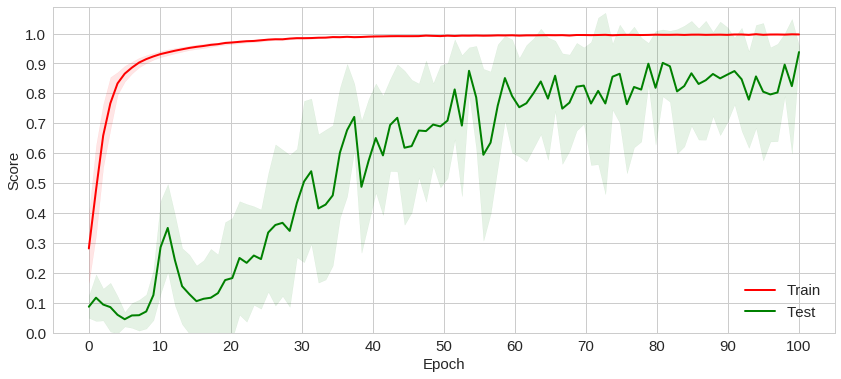

In [25]:
plot_mean_acc(hist)

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

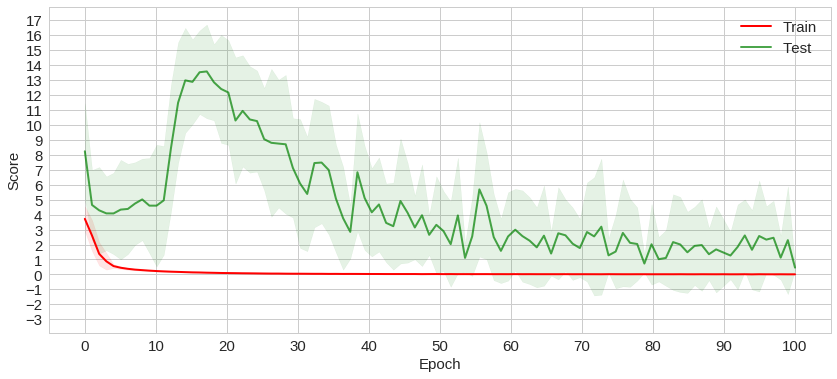

In [27]:
plot_mean_loss(hist)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
        
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.set_xlabel("Epoch", fontsize=text_fontsize)
    ax1.set_ylabel("Accuracy", fontsize=text_fontsize)
    ax1.grid(True)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax1.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax1.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train acc")
    ax1.plot(epochs, test_scores_mean, '-', color="b", linewidth=2.0, label="Test acc")
    ax1.plot(np.argmax(test_scores_mean)+1, np.max(test_scores_mean), 'o', color="k", label=None)
    ax1.annotate('Max acc: %.4f (Epoch: %d)' %(np.max(test_scores_mean),np.argmax(test_scores_mean)), xy=(np.argmax(test_scores_mean)+1, np.max(test_scores_mean)), xytext=(np.argmax(test_scores_mean)-15, np.max(test_scores_mean)-0.2), arrowprops=dict(facecolor='k', shrink=0.05),)
    ax1.tick_params(labelsize=text_fontsize)
    ax1.legend(loc="lower left", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    ax2 = ax1.twinx()
    ax2.set_xlabel("Epoch", fontsize=text_fontsize)
    ax2.set_ylabel("Loss", fontsize=text_fontsize)
    ax2.grid(False)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax2.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax2.plot(epochs, train_scores_mean, '--', color="r", linewidth=2.0, label="Train loss")
    ax2.plot(epochs, test_scores_mean, '--', color="b", linewidth=2.0, label="Test loss")
    ax2.tick_params(labelsize=text_fontsize)
    ax2.legend(loc="lower right", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-1.9,8.9))
    plt.show()

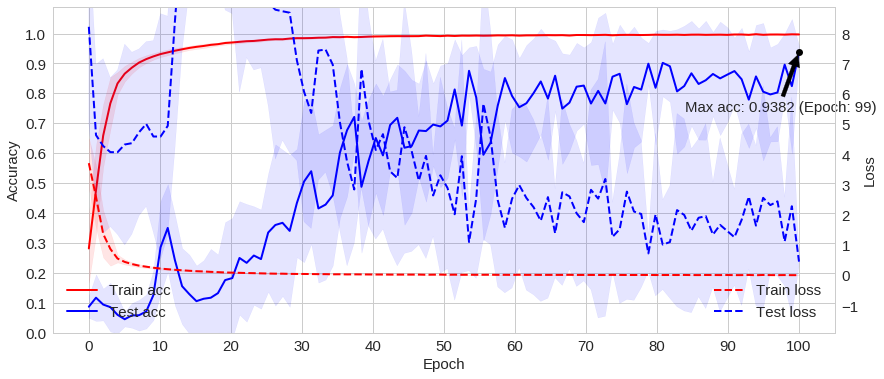

In [29]:
plot_mean(hist)